In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
plt.rcParams.update({'figure.figsize':(15,12), 'figure.dpi':120})

## Load Data

In [2]:
base_data = pd.read_csv('data.csv', index_col=0)
base_data.index = pd.to_datetime(base_data.index)
base_data = base_data.asfreq('H')

imputed_data = base_data.copy()
for idx, row in imputed_data.iterrows():
    if np.isnan(row.tmp_f_KDFW):
        imputed_data.loc[idx].tmp_f_KDFW = base_data[
                                                    (base_data.index.month == idx.month) & 
                                                    (base_data.index.day == idx.day) & 
                                                    (base_data.index.hour == idx.hour)
                                                ].tmp_f_KDFW.mean()

In [3]:
train_data = imputed_data[imputed_data.index < '2021-07-01']
train_data = train_data.asfreq('H')
target_data = imputed_data[imputed_data.index >= '2021-07-01']
target_data = target_data.asfreq('H')

In [4]:
scaler = MinMaxScaler()
train_data[['tmp_f_KDFW', 'north_load']] = scaler.fit_transform(train_data[['tmp_f_KDFW', 'north_load']])

In [5]:
train_data.fillna(0, inplace=True)

## Test Stationarity

In [9]:
result = adfuller(train_data.north_load)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -10.083973
p-value: 0.000000


Reject the null hypothesis of non-stationarity. The time series is therefore (likely) stationary and so we'll set d=0 --> It is possible that we're overpowered here because we have LOTS of data.

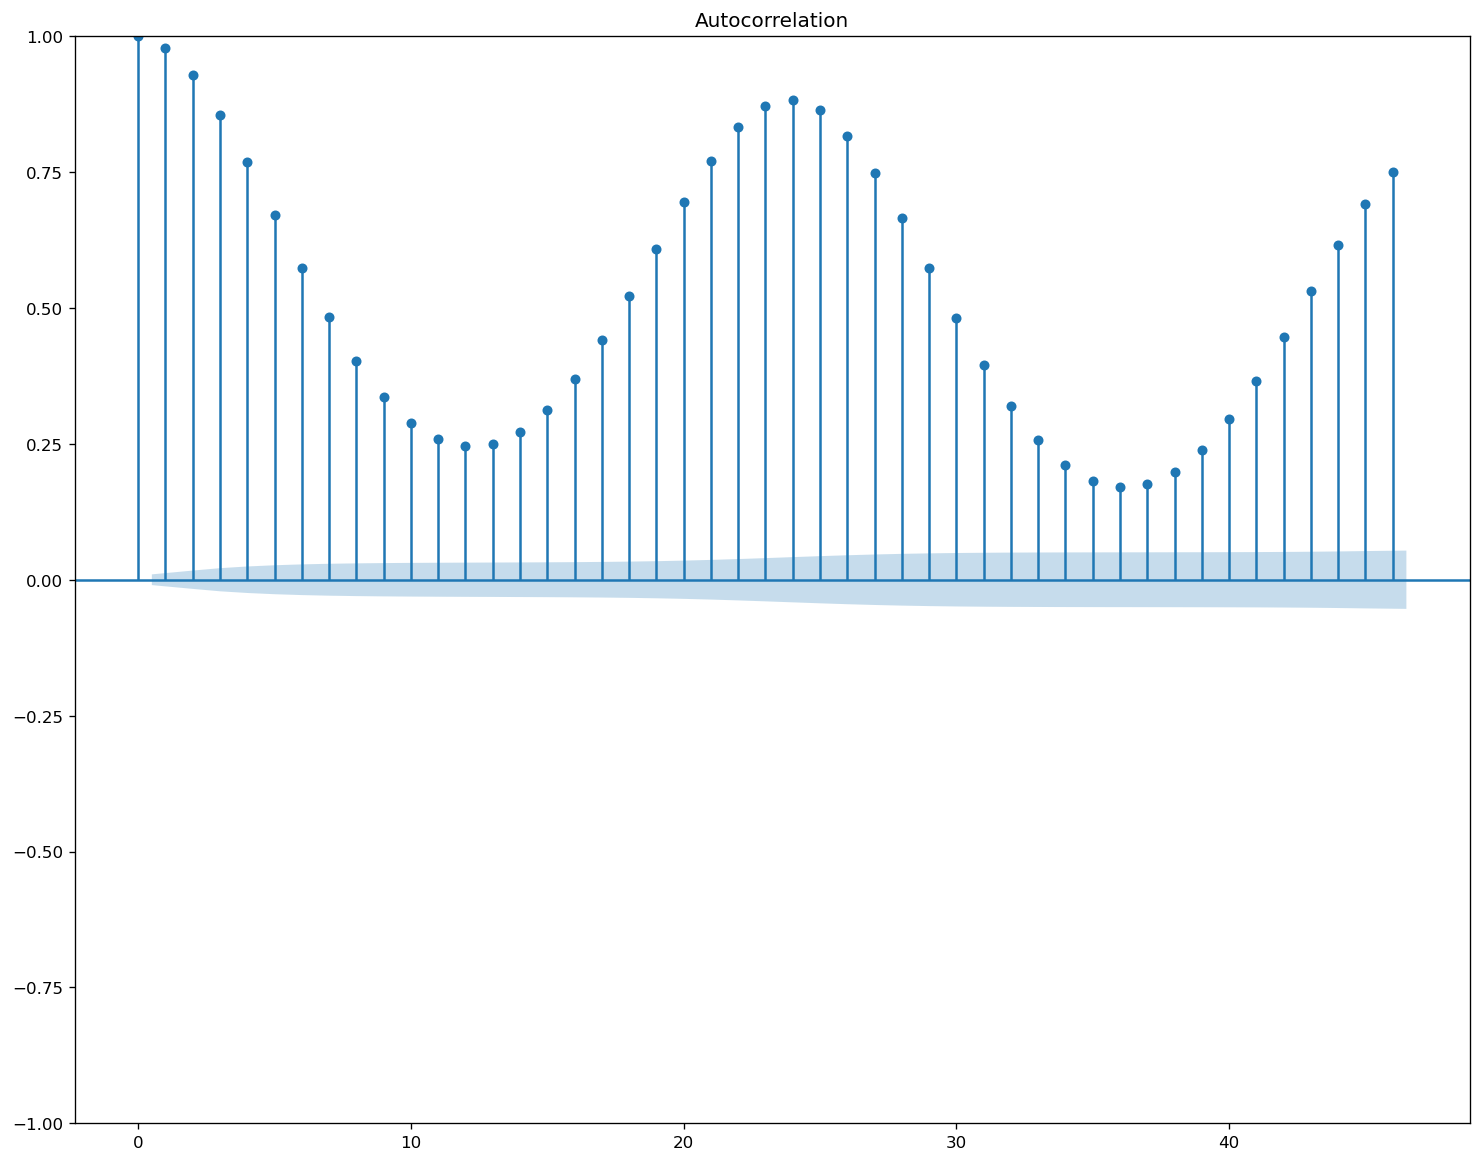

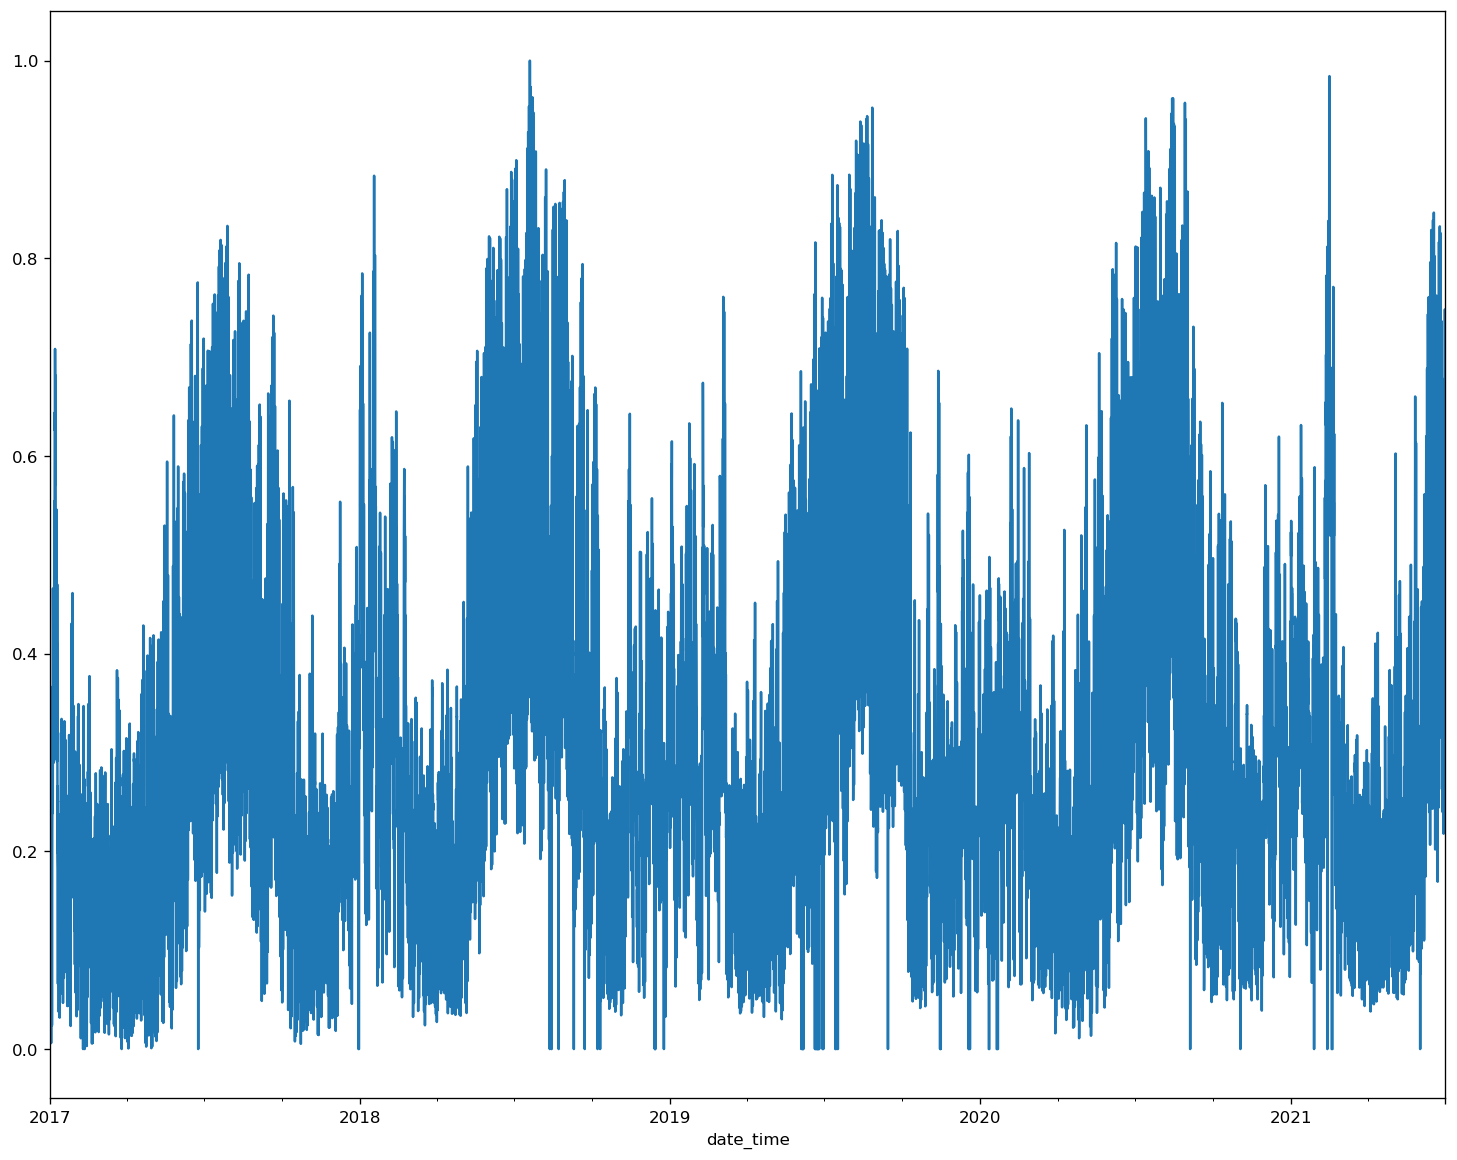

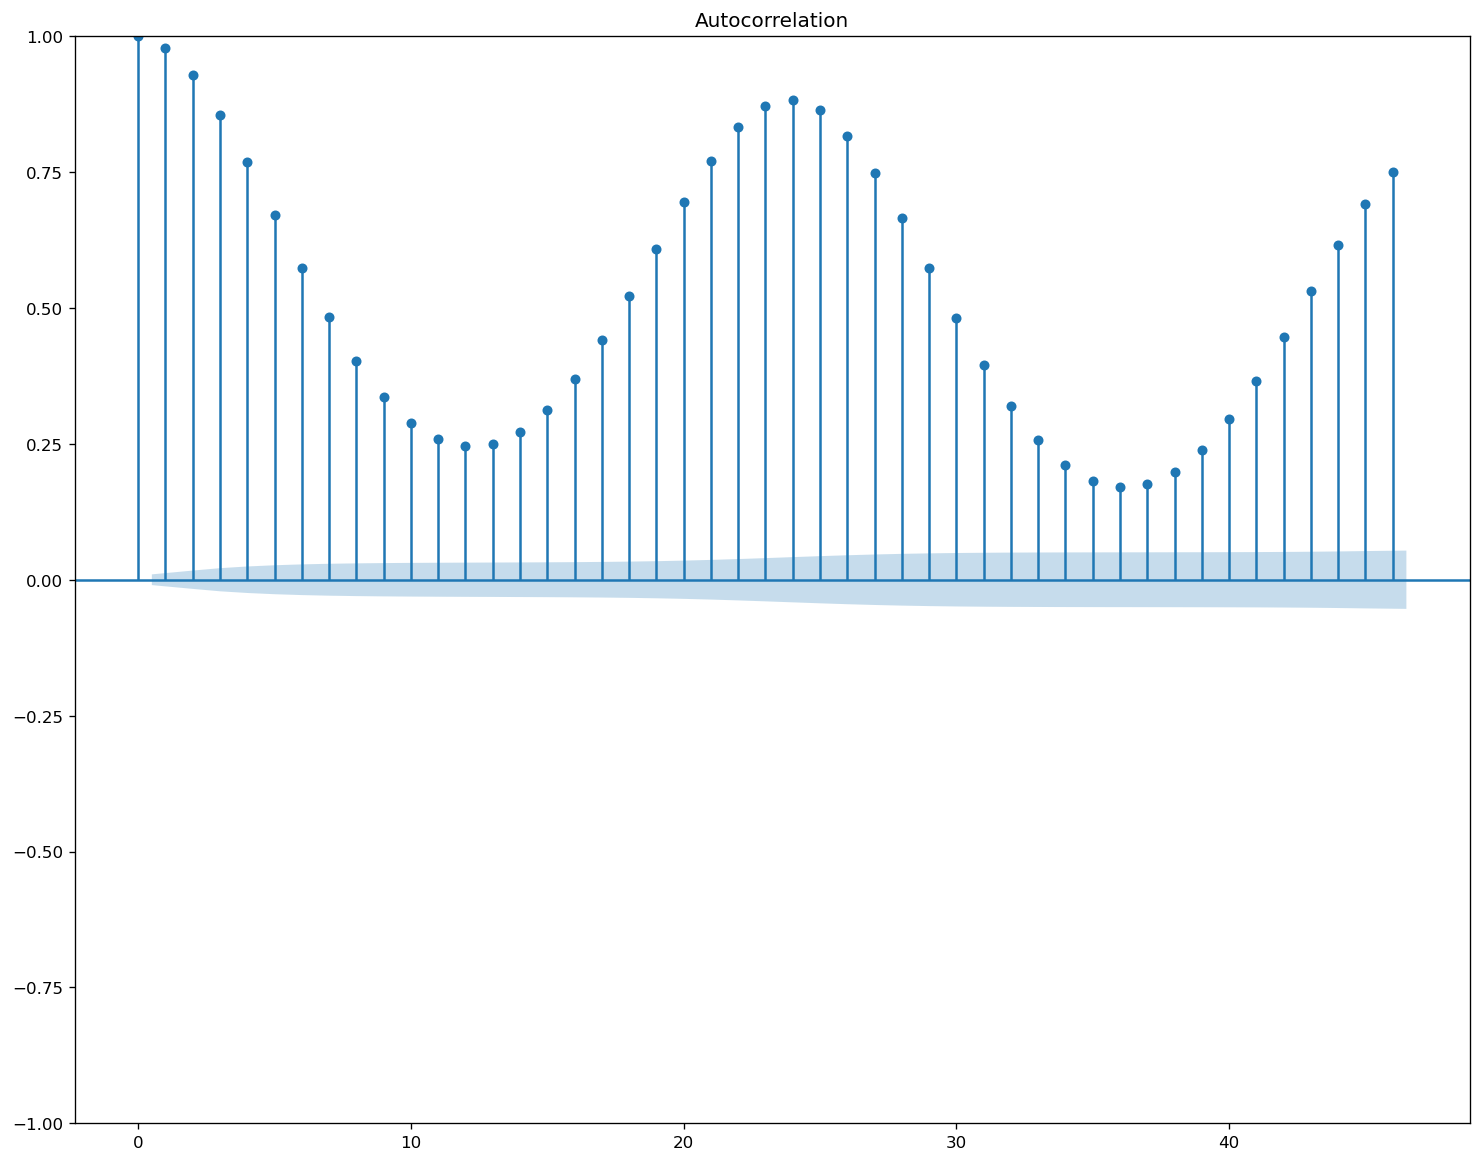

In [28]:
fig, ax = plt.subplots()
train_data.north_load.plot(ax=ax)
plot_acf(train_data.north_load)

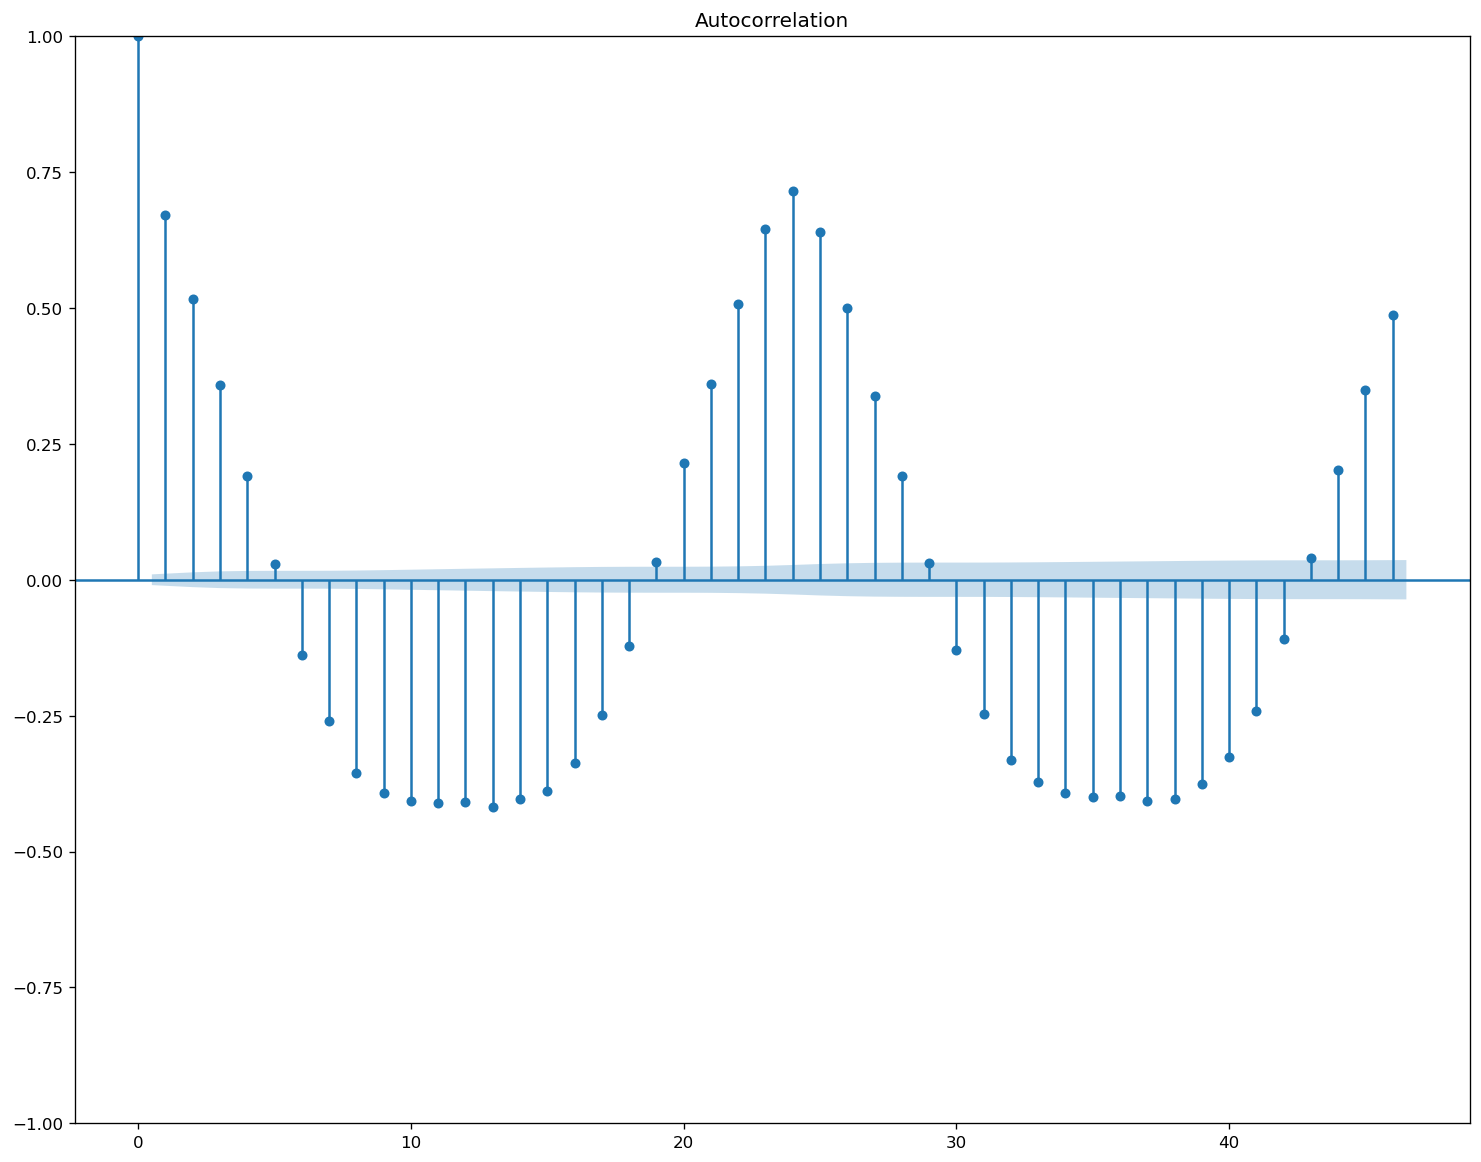

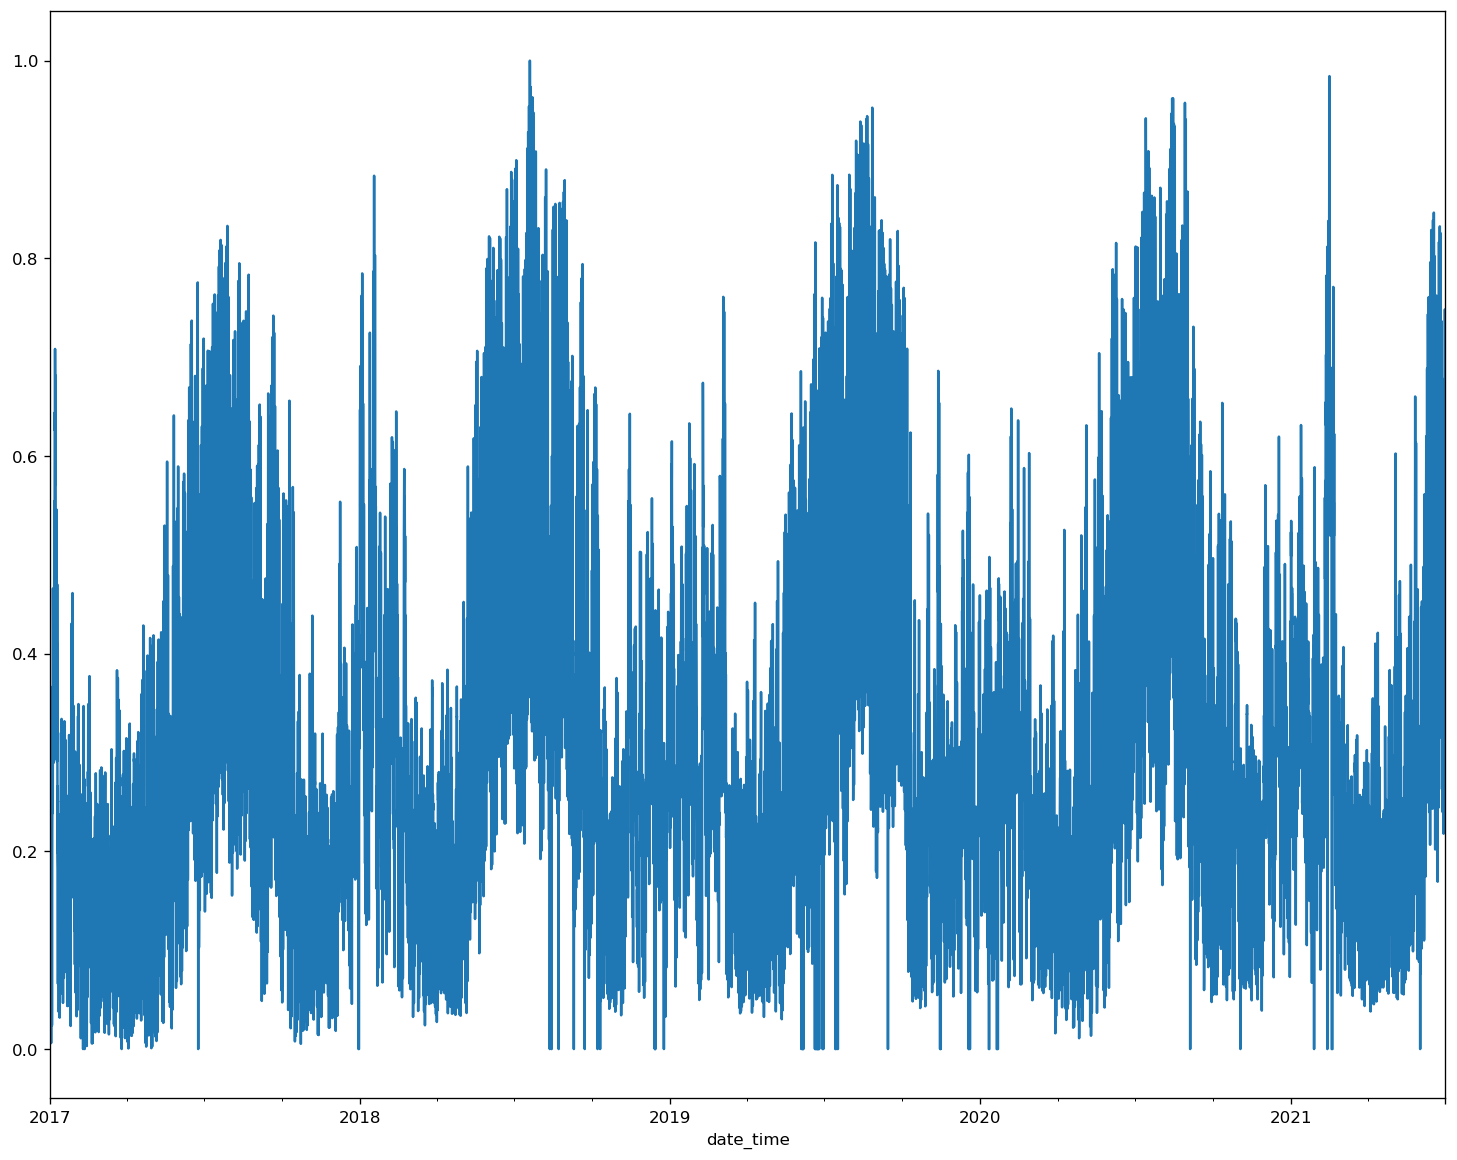

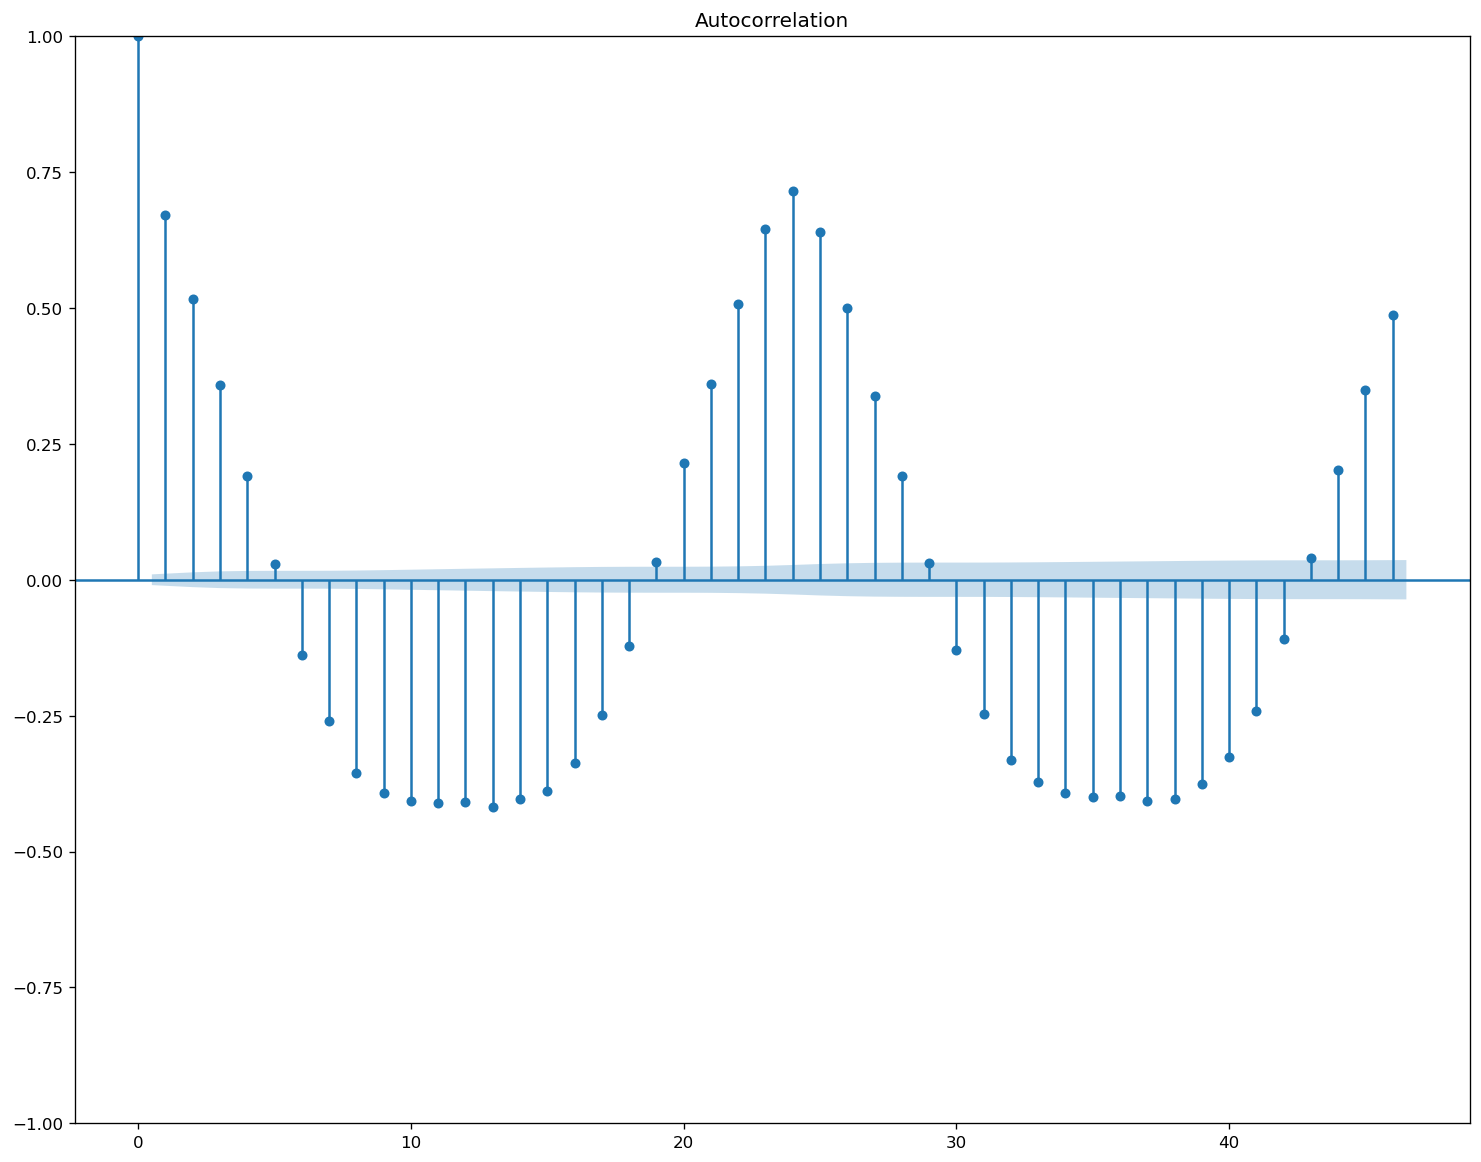

In [33]:
fig, ax = plt.subplots()
train_data.north_load.plot(ax=ax)
plot_acf(train_data.diff().north_load.dropna())

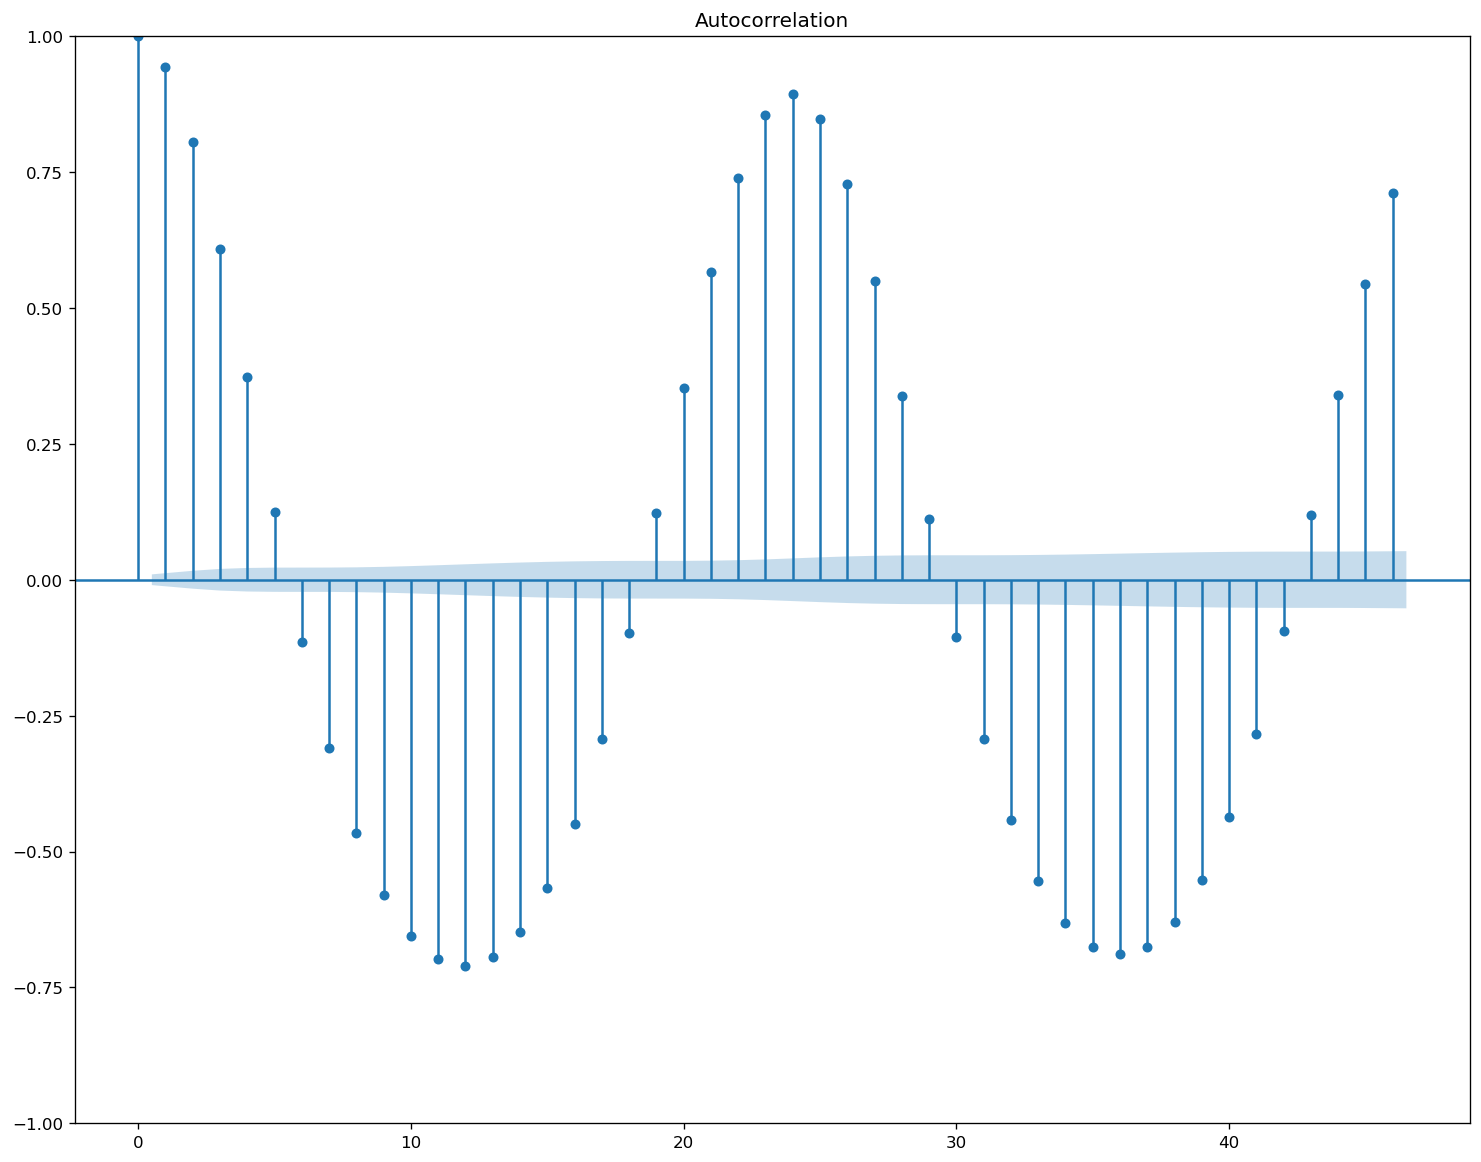

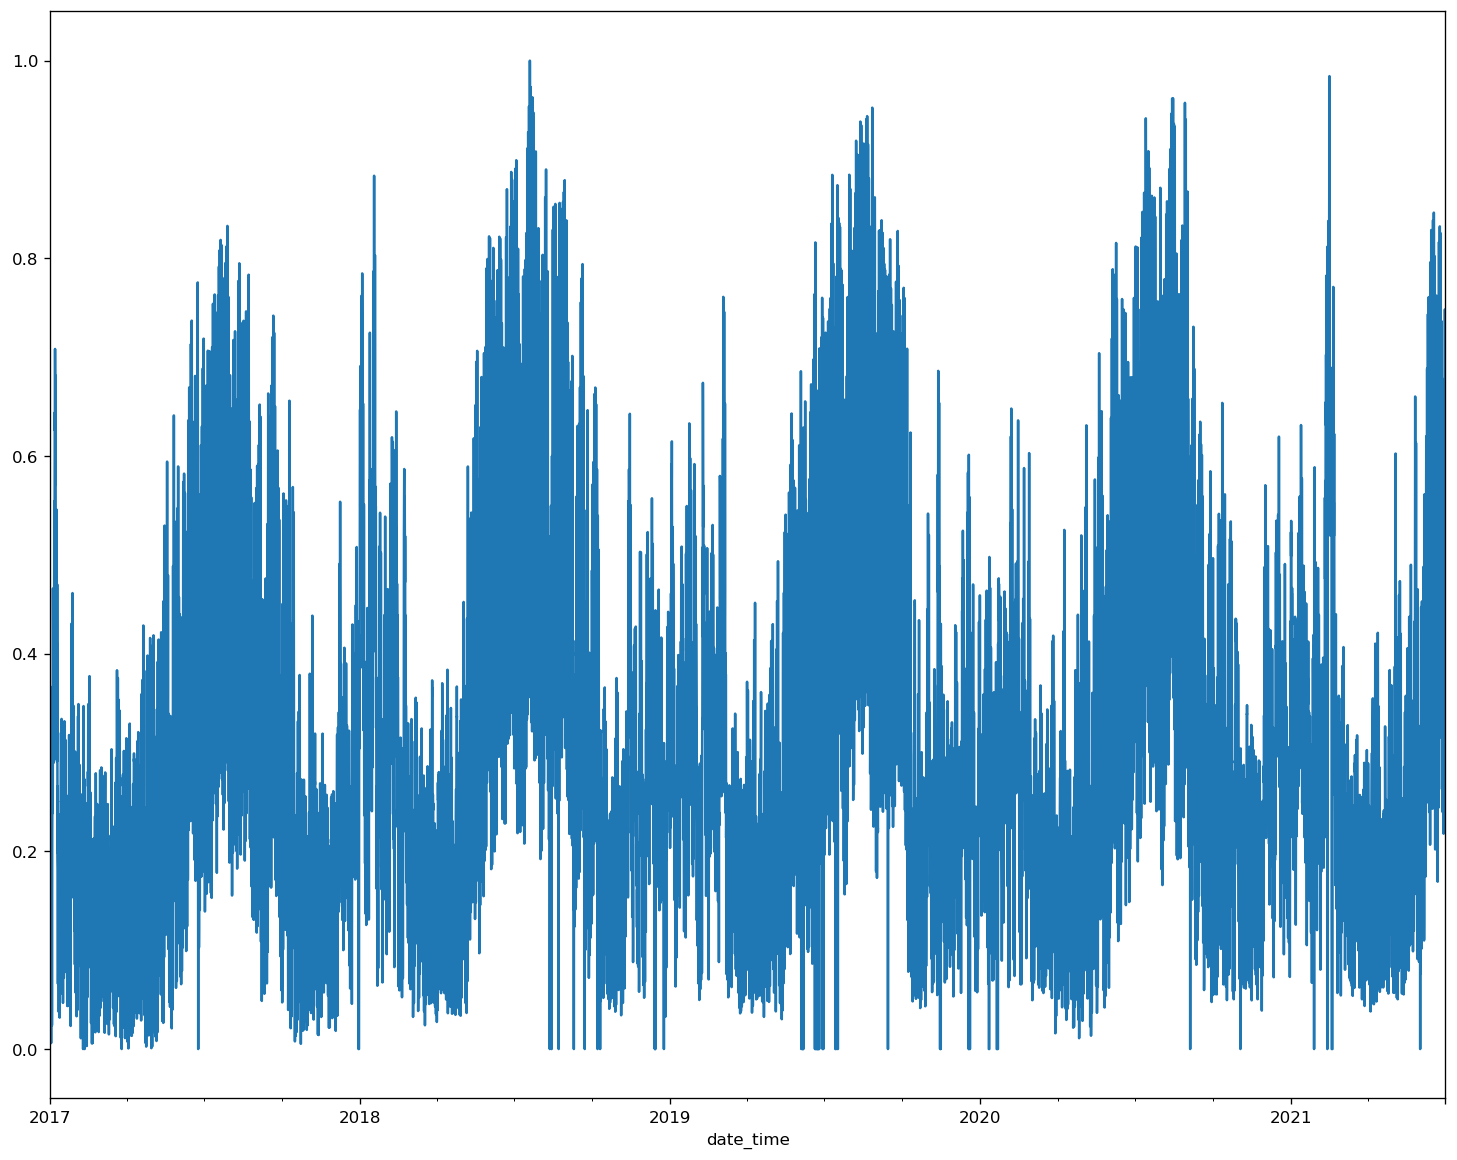

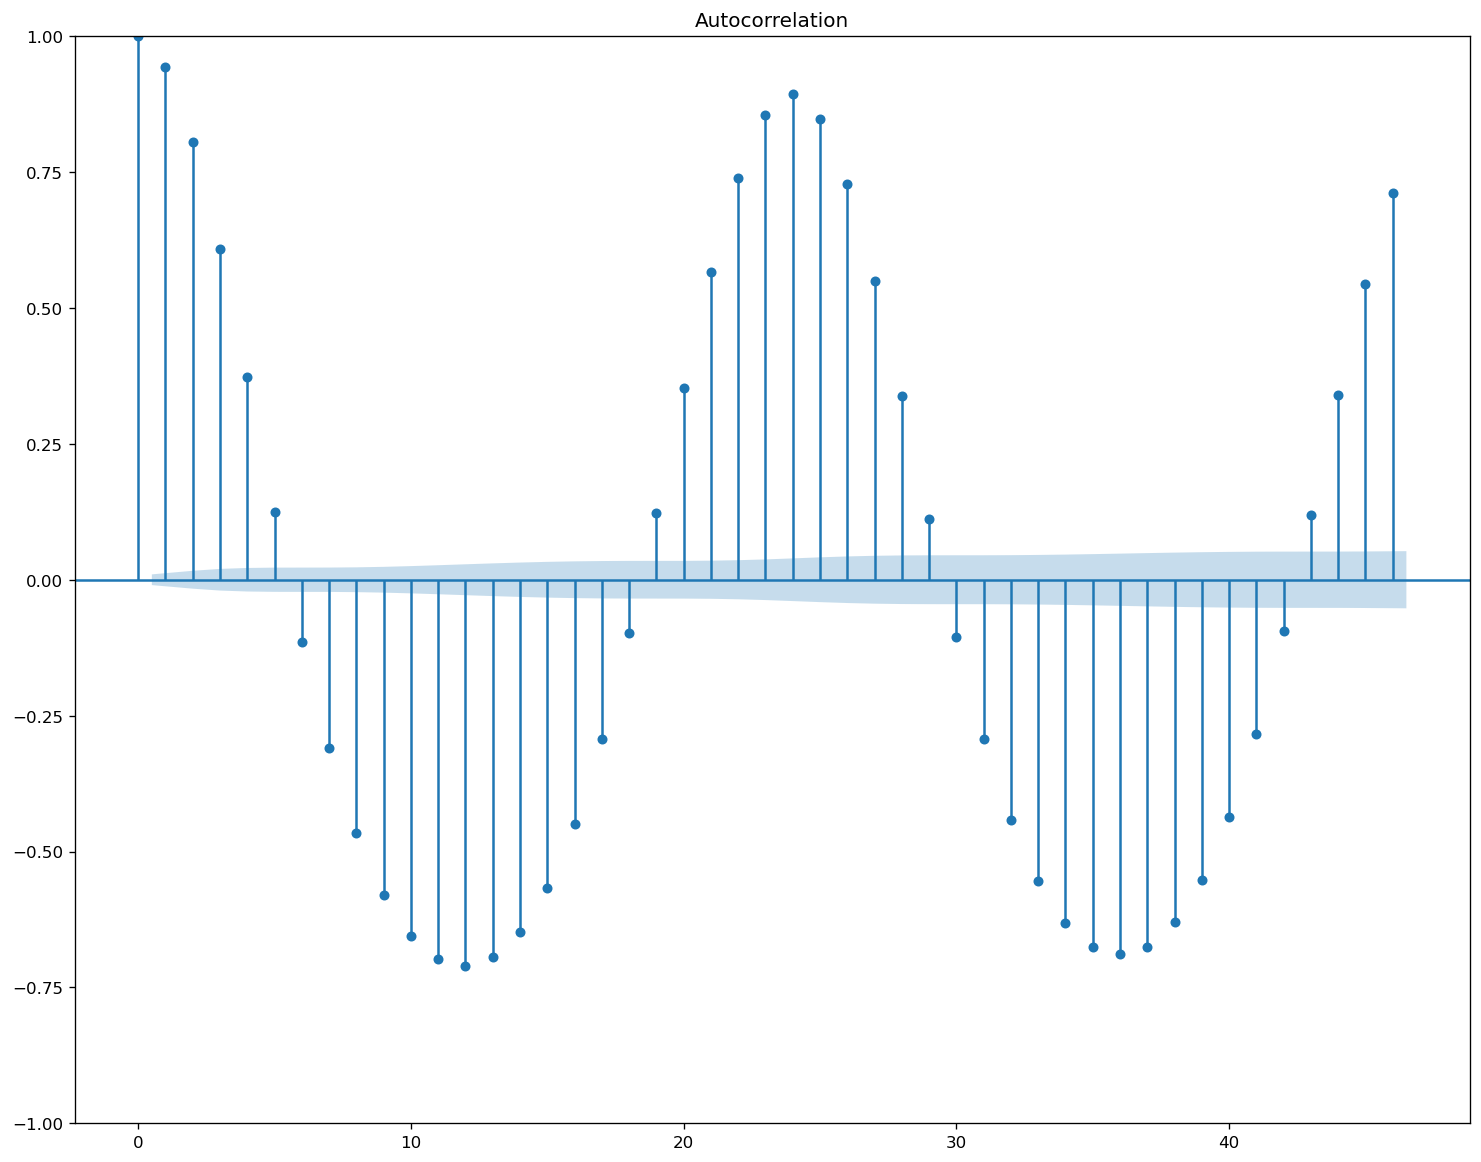

In [56]:
fig, ax = plt.subplots()
train_data.north_load.plot(ax=ax)
plot_acf(train_data.diff(6).north_load.dropna())

## Find the Number of Lags

/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


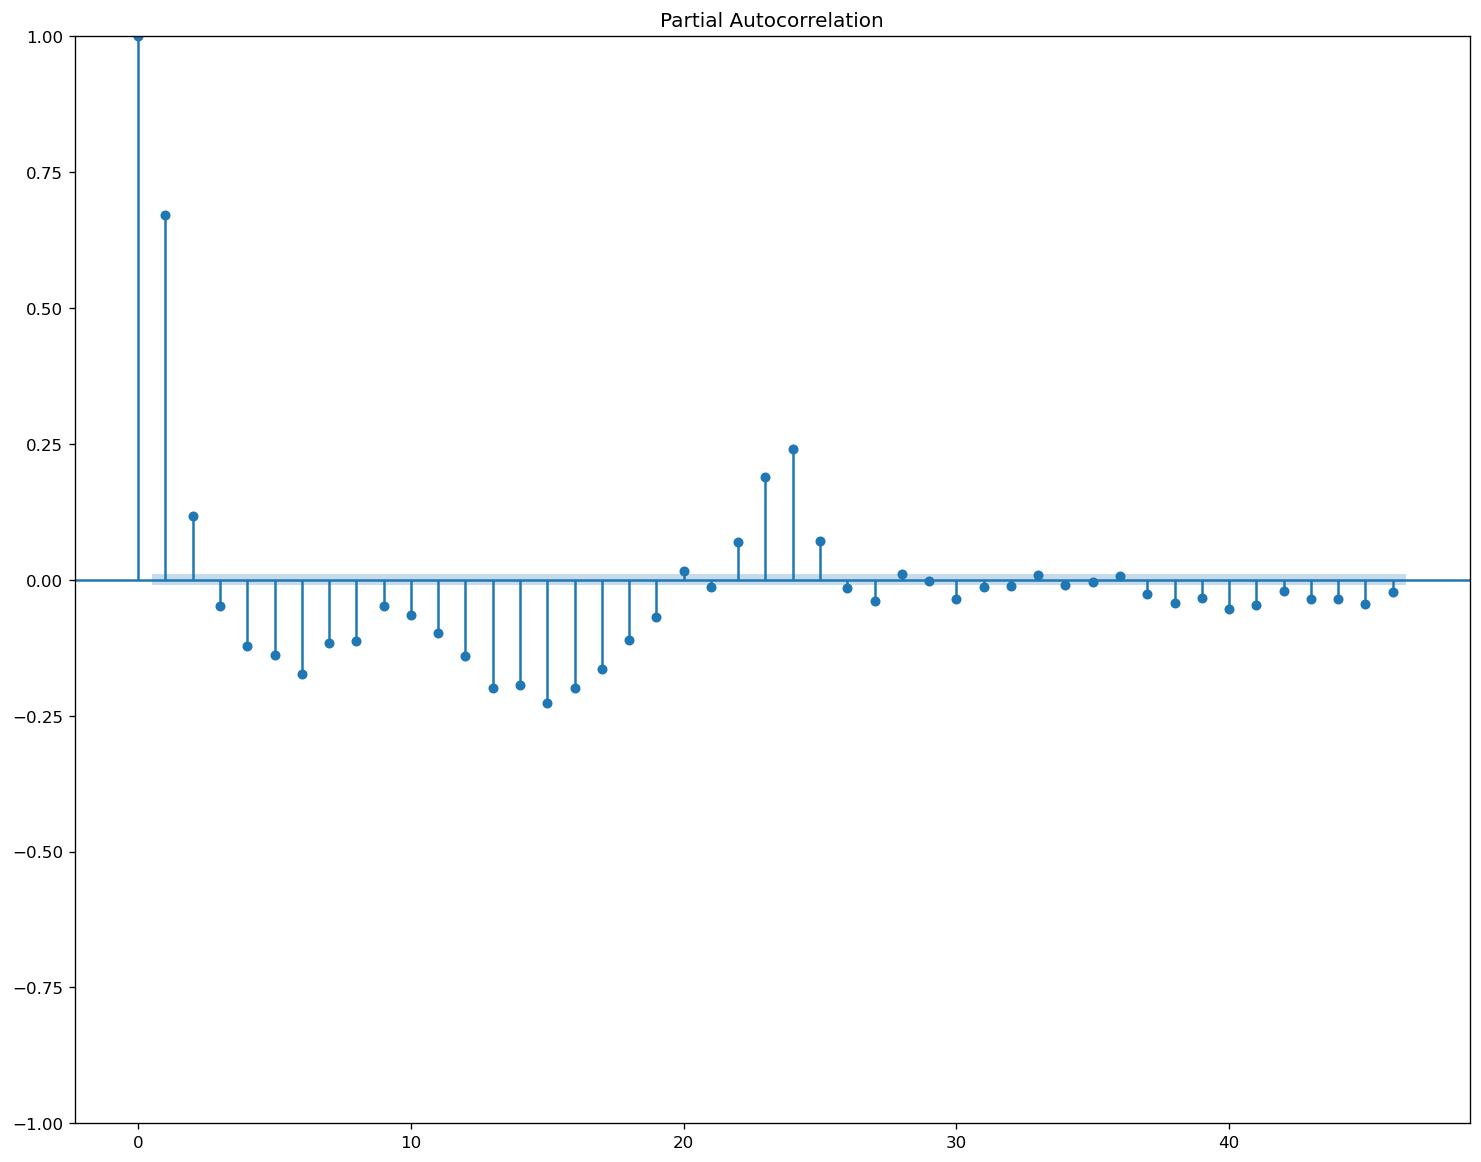

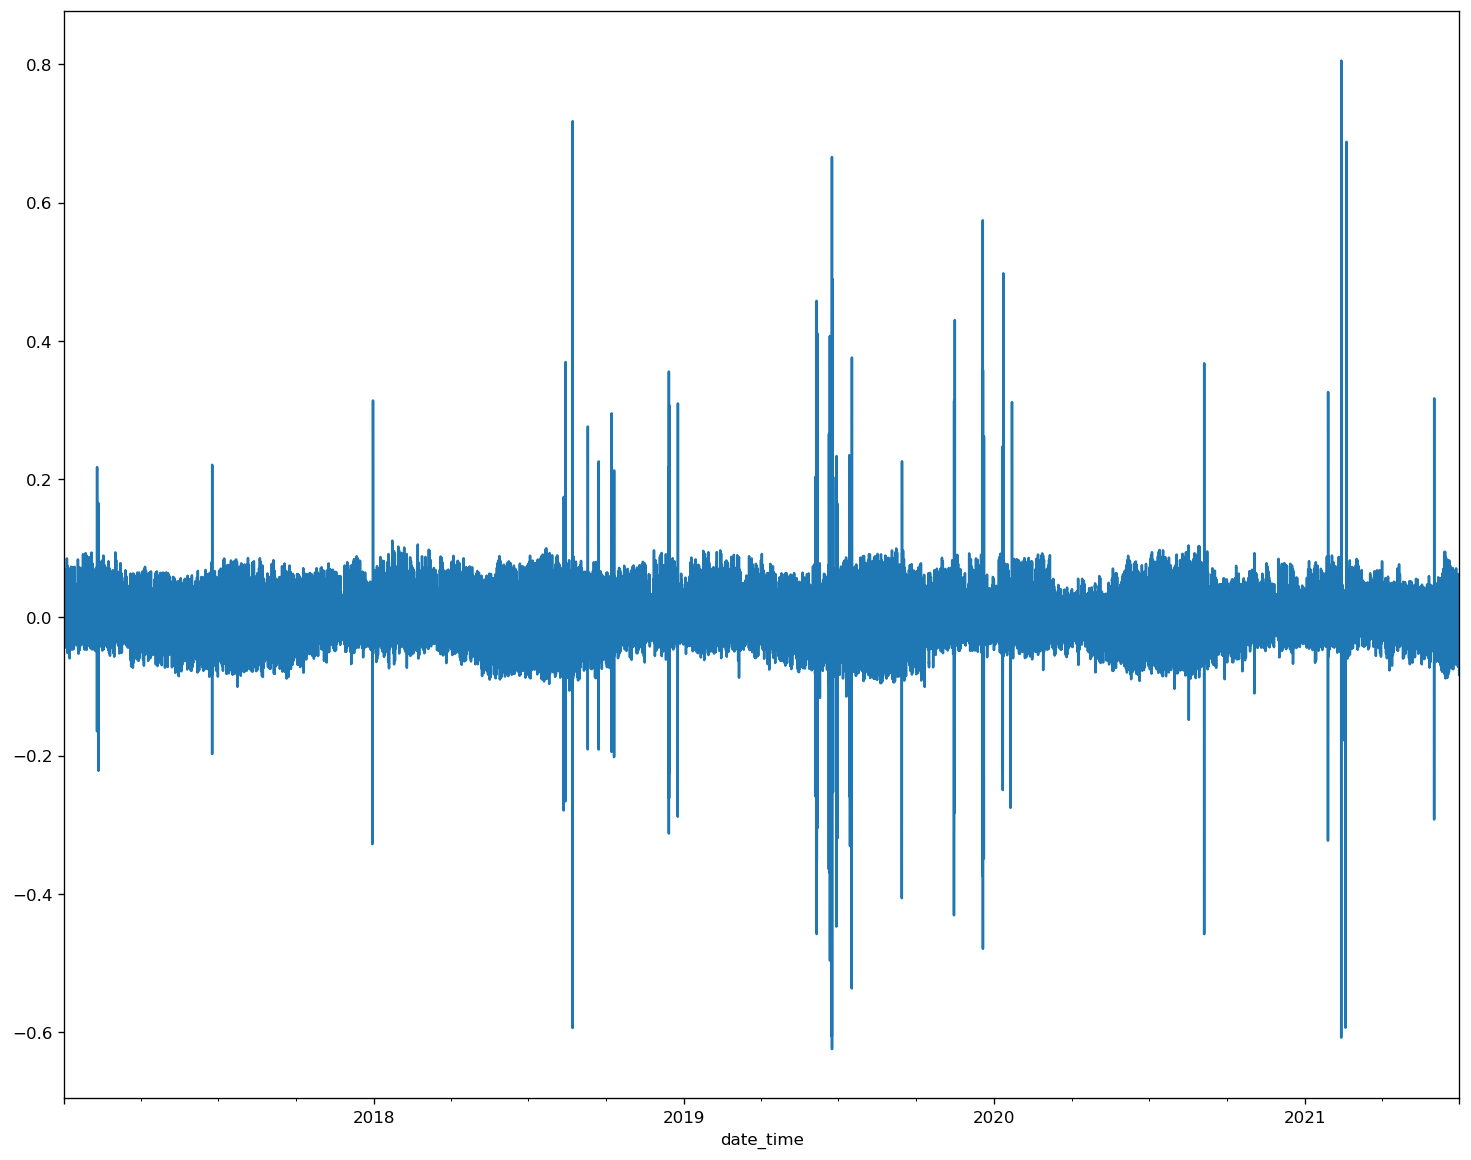

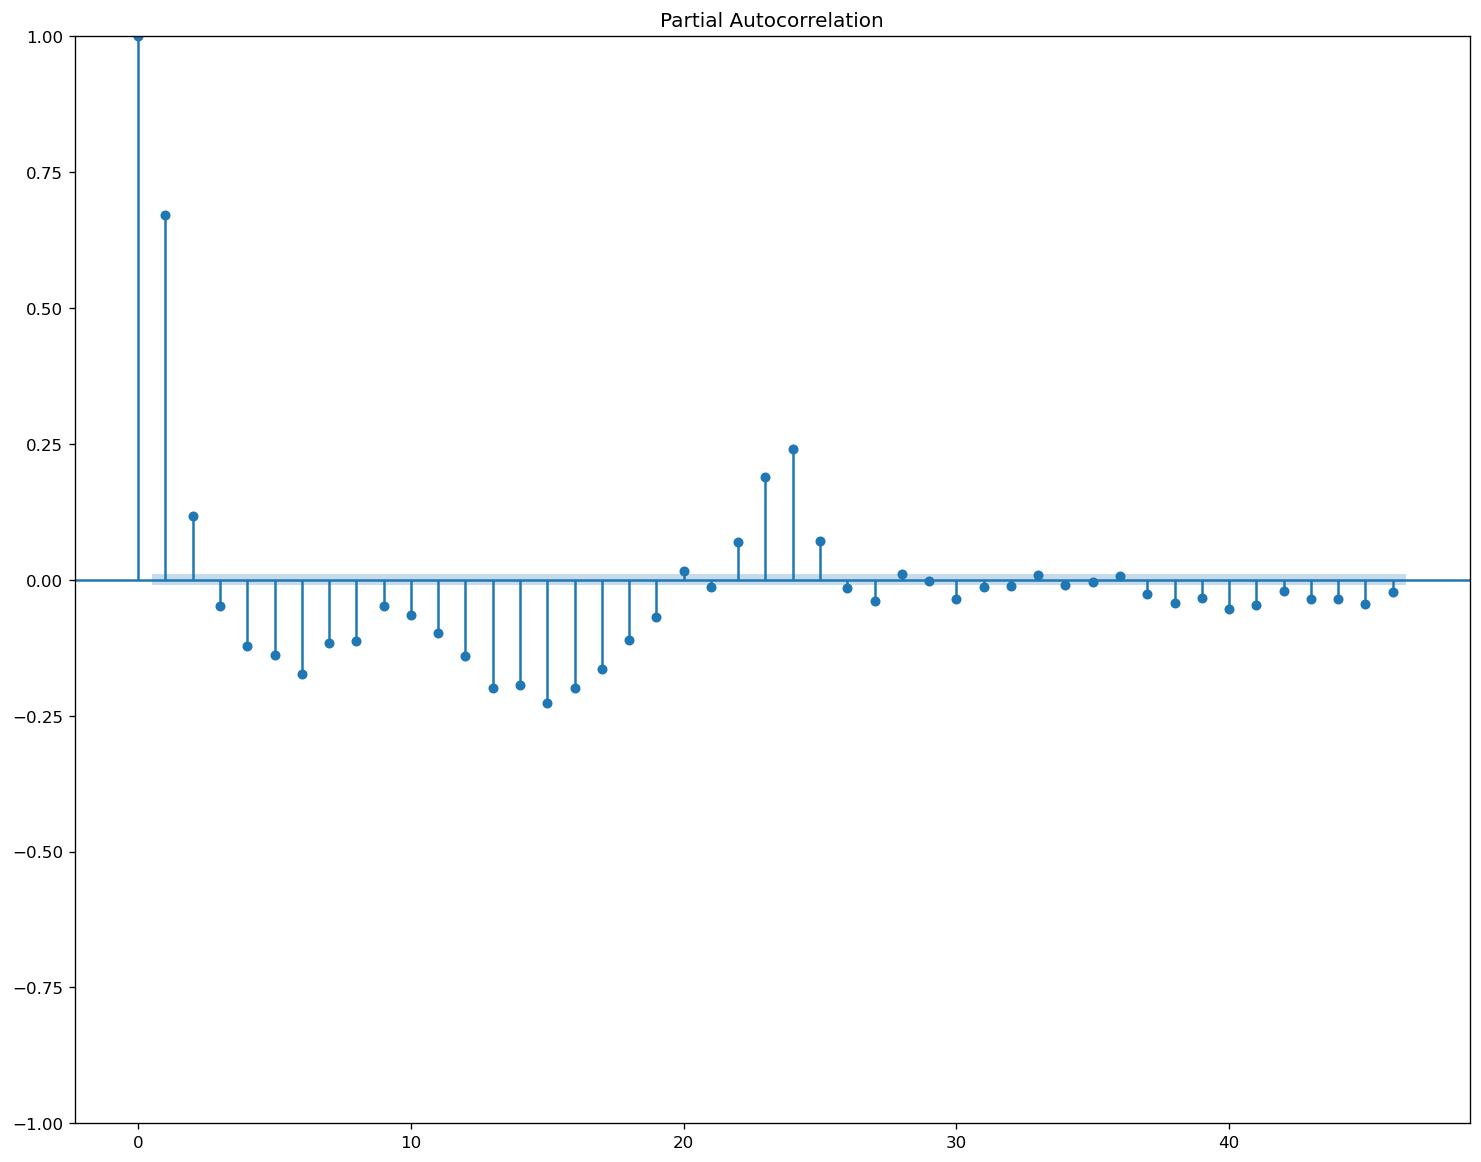

In [35]:
fig, ax = plt.subplots()
train_data.diff().dropna().north_load.plot()
plot_pacf(train_data.diff().dropna().north_load)

It appears we're below the alpha (.05) significance level after the ~18th lag -> We'll set p=18

## Picking q (MA parameter)

There are about 5 lags above the significance line in the ACF plot above so we'll go with that.

## Fit ARIMA(18, 1, 5)

In [58]:
model = sm.tsa.ARIMA(train_data.north_load, order=(18,1,5))
model_fit = model.fit()
print(model_fit.summary())

/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:                ARIMA(18, 1, 5)   Log Likelihood               91639.632
Date:                Fri, 17 Jun 2022   AIC                        -183231.265
Time:                        21:55:11   BIC                        -183025.304
Sample:                    01-01-2017   HQIC                       -183166.027
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1820      0.031      5.779      0.000       0.120       0.244
ar.L2          0.2077      0.035      5.936      0.000       0.139       0.276
ar.L3          0.1910      0.031      6.137      0.0

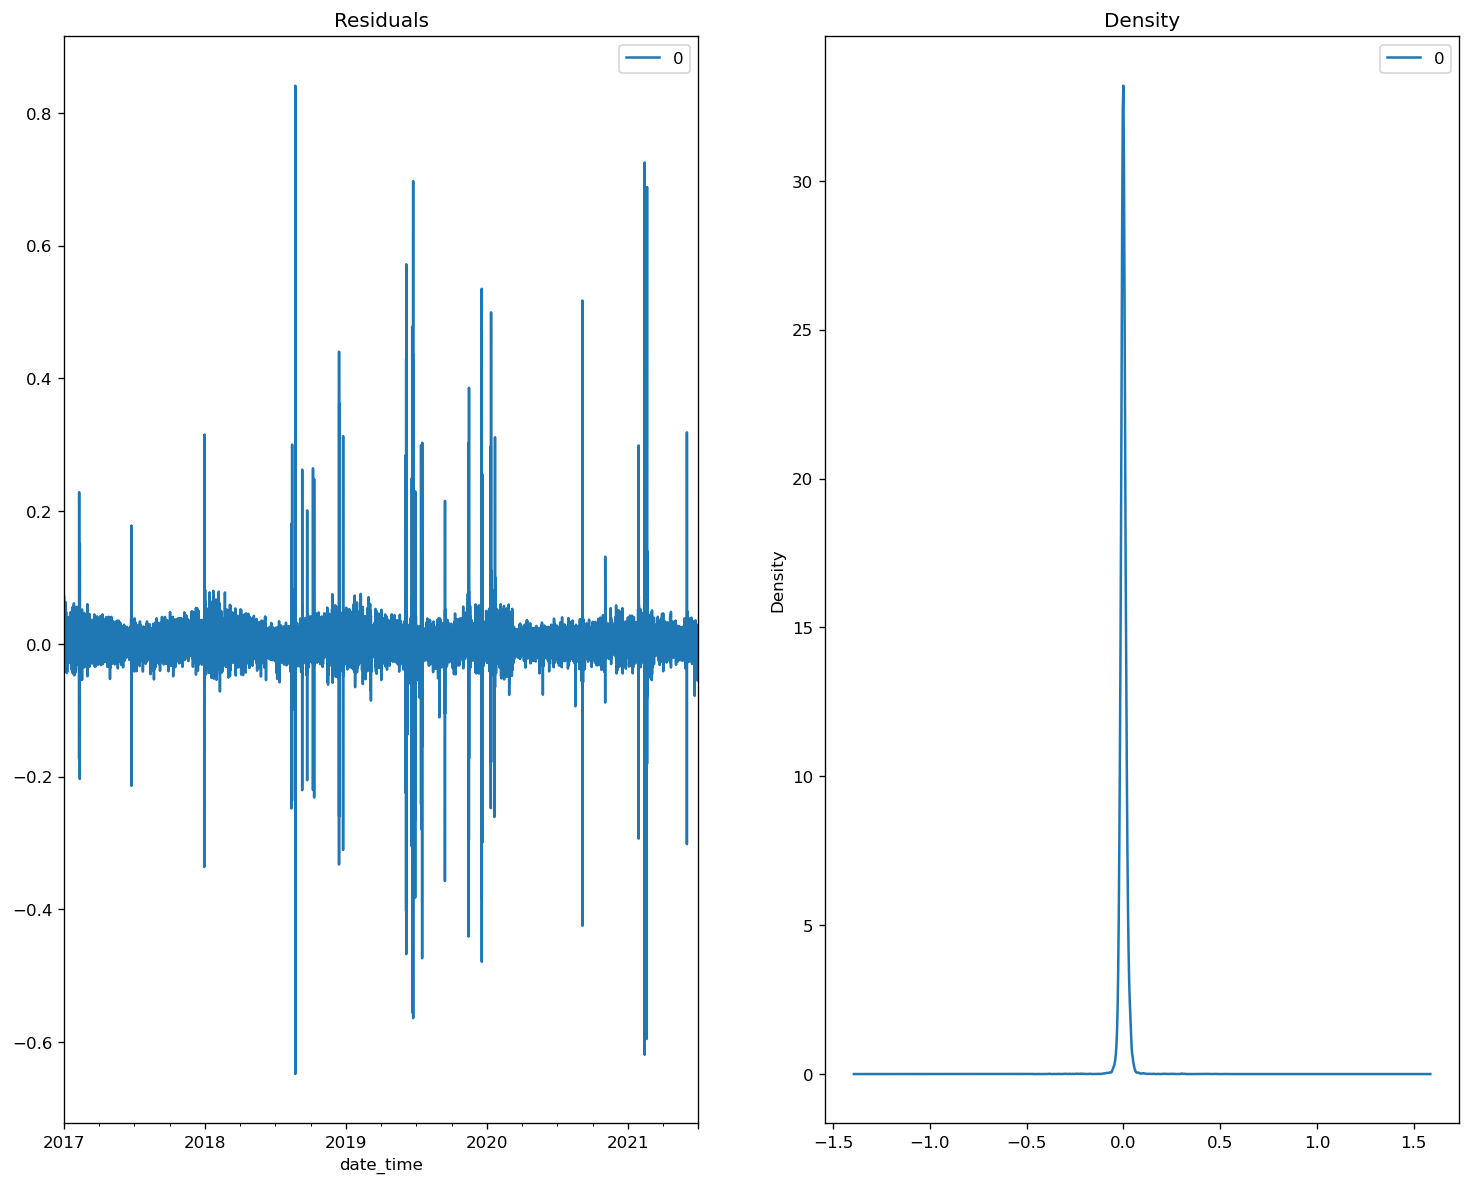

In [59]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

<AxesSubplot:xlabel='date_time'>

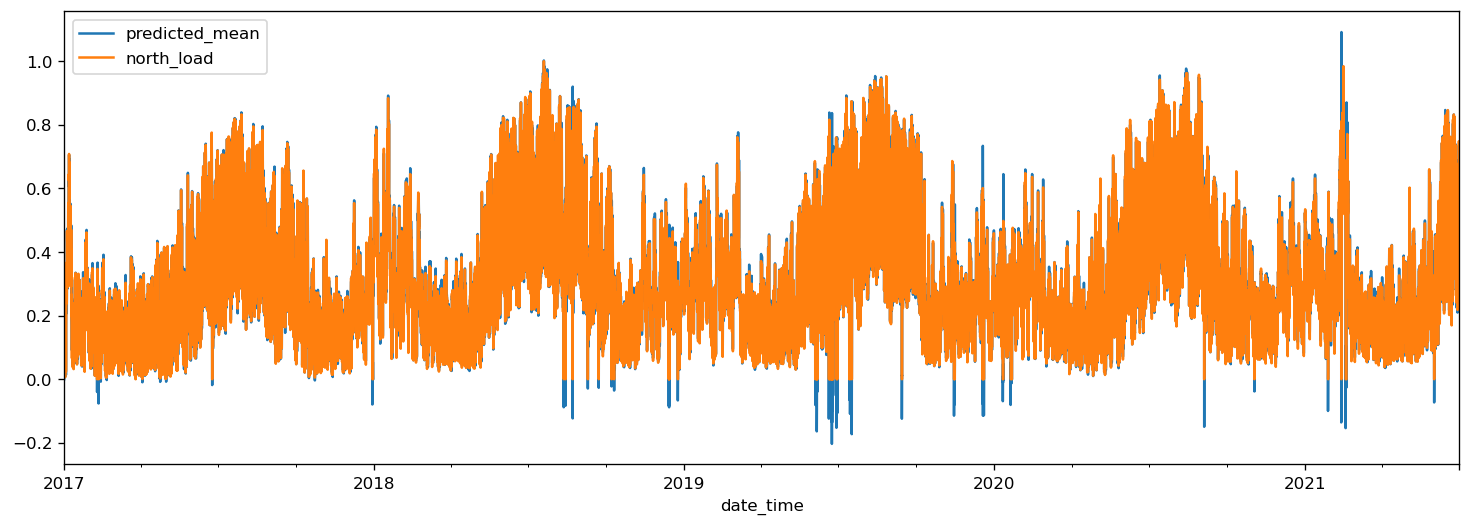

In [60]:
fig, ax = plt.subplots(figsize=(15, 5))
in_model_predictions = model_fit.predict()
in_model_predictions.plot(ax=ax, legend=True)
train_data.north_load.plot(ax=ax, legend=True)

## Analysis to here:

Residuals plots generally look "fine". No clear trends.

## Fit ARIMA(18, 1, 5) With Temperature

In [61]:
model = sm.tsa.ARIMA(train_data.north_load, exog=train_data.tmp_f_KDFW, order=(18,1,5))
model_fit = model.fit()
print(model_fit.summary())

/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:                ARIMA(18, 1, 5)   Log Likelihood               91897.575
Date:                Fri, 17 Jun 2022   AIC                        -183745.150
Time:                        22:00:58   BIC                        -183530.608
Sample:                    01-01-2017   HQIC                       -183677.194
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tmp_f_KDFW    -0.3382      0.002   -184.125      0.000      -0.342      -0.335
ar.L1          0.1227      0.025      4.846      0.000       0.073       0.172
ar.L2          0.0626      0.040      1.571      0.1

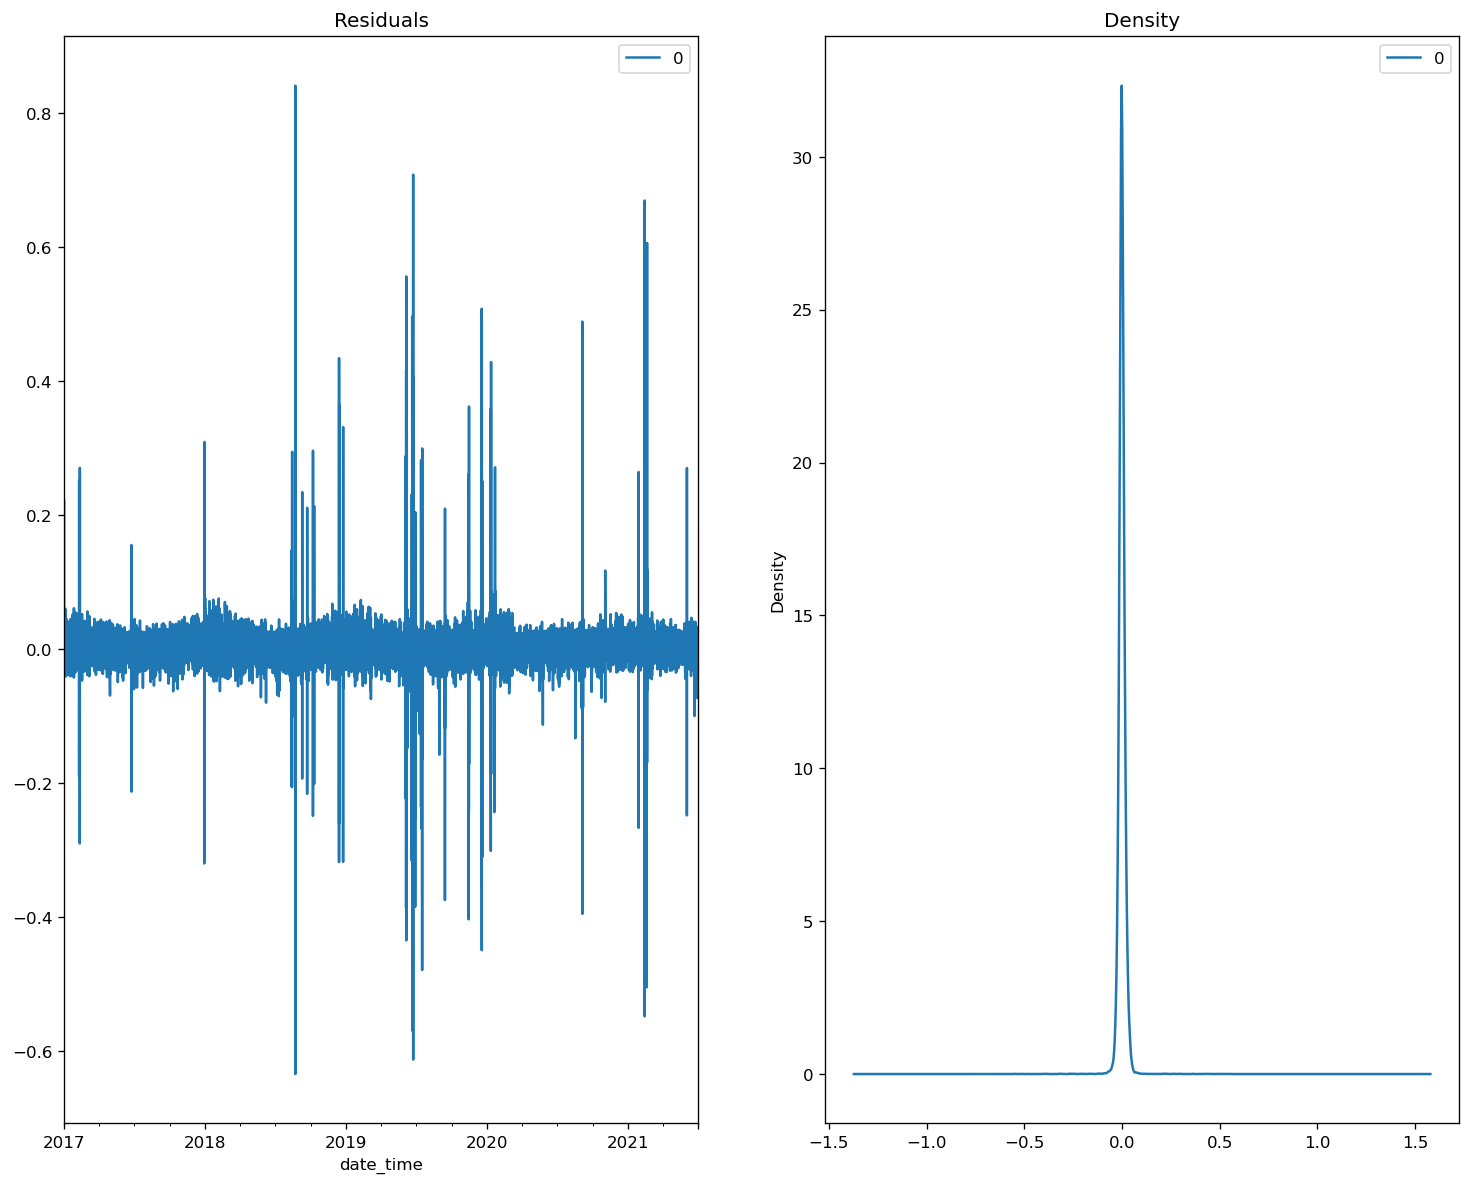

In [62]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

<AxesSubplot:xlabel='date_time'>

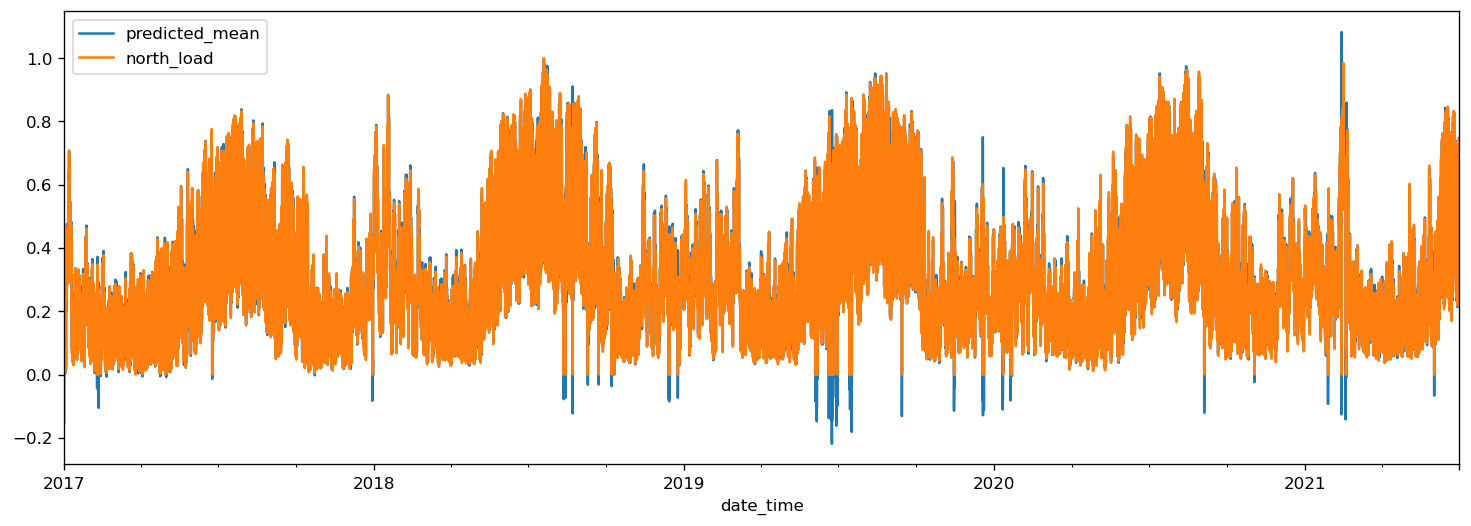

In [63]:
fig, ax = plt.subplots(figsize=(15, 5))
in_model_predictions = model_fit.predict()
in_model_predictions.plot(ax=ax, legend=True)
train_data.north_load.plot(ax=ax, legend=True)

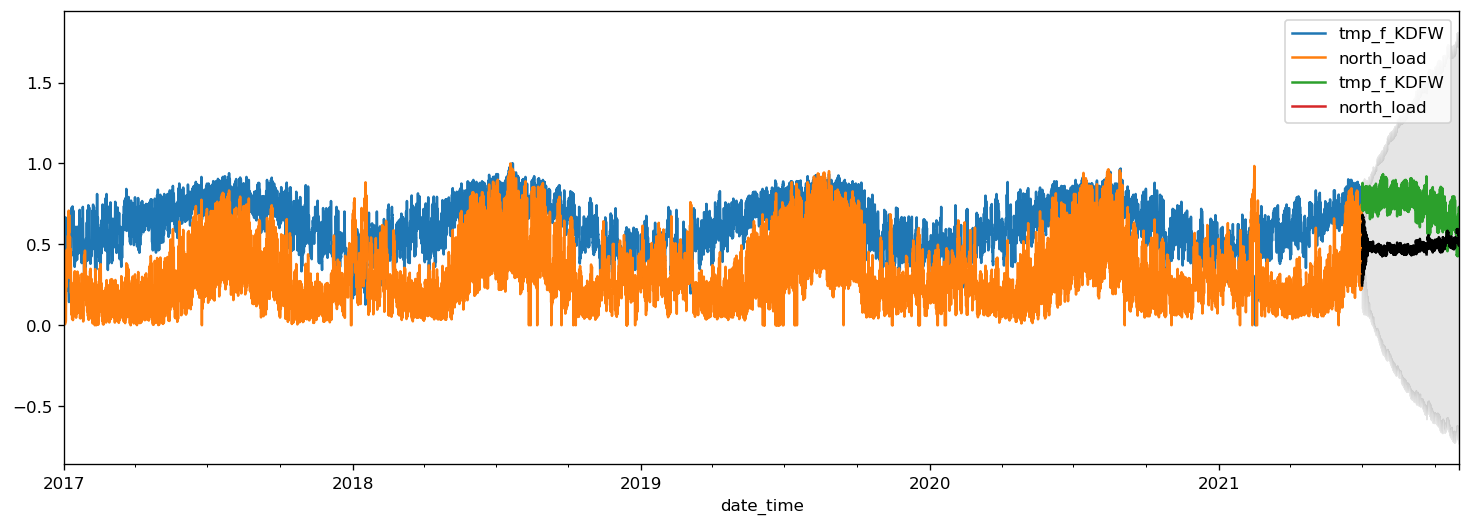

In [64]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2017-01-01':].plot(ax=ax)
target_trans = target_data.copy()
target_trans[['tmp_f_KDFW', 'north_load']] = scaler.transform(target_data[['tmp_f_KDFW', 'north_load']])
target_trans.plot(ax=ax)

# Construct the forecasts
fcast = model_fit.get_forecast(target_data.index[-1], exog=target_trans.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

## Fit ARIMA(24, 1, 5) With Temperature

In [65]:
model = sm.tsa.ARIMA(train_data.north_load, exog=train_data.tmp_f_KDFW, order=(24,1,5))
model_fit = model.fit()
print(model_fit.summary())

/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:                ARIMA(24, 1, 5)   Log Likelihood               93716.532
Date:                Fri, 17 Jun 2022   AIC                        -187371.064
Time:                        22:13:21   BIC                        -187105.031
Sample:                    01-01-2017   HQIC                       -187286.798
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tmp_f_KDFW    -0.2727      0.002   -149.111      0.000      -0.276      -0.269
ar.L1          0.1565      0.010     15.822      0.000       0.137       0.176
ar.L2          0.0482      0.012      4.075      0.0

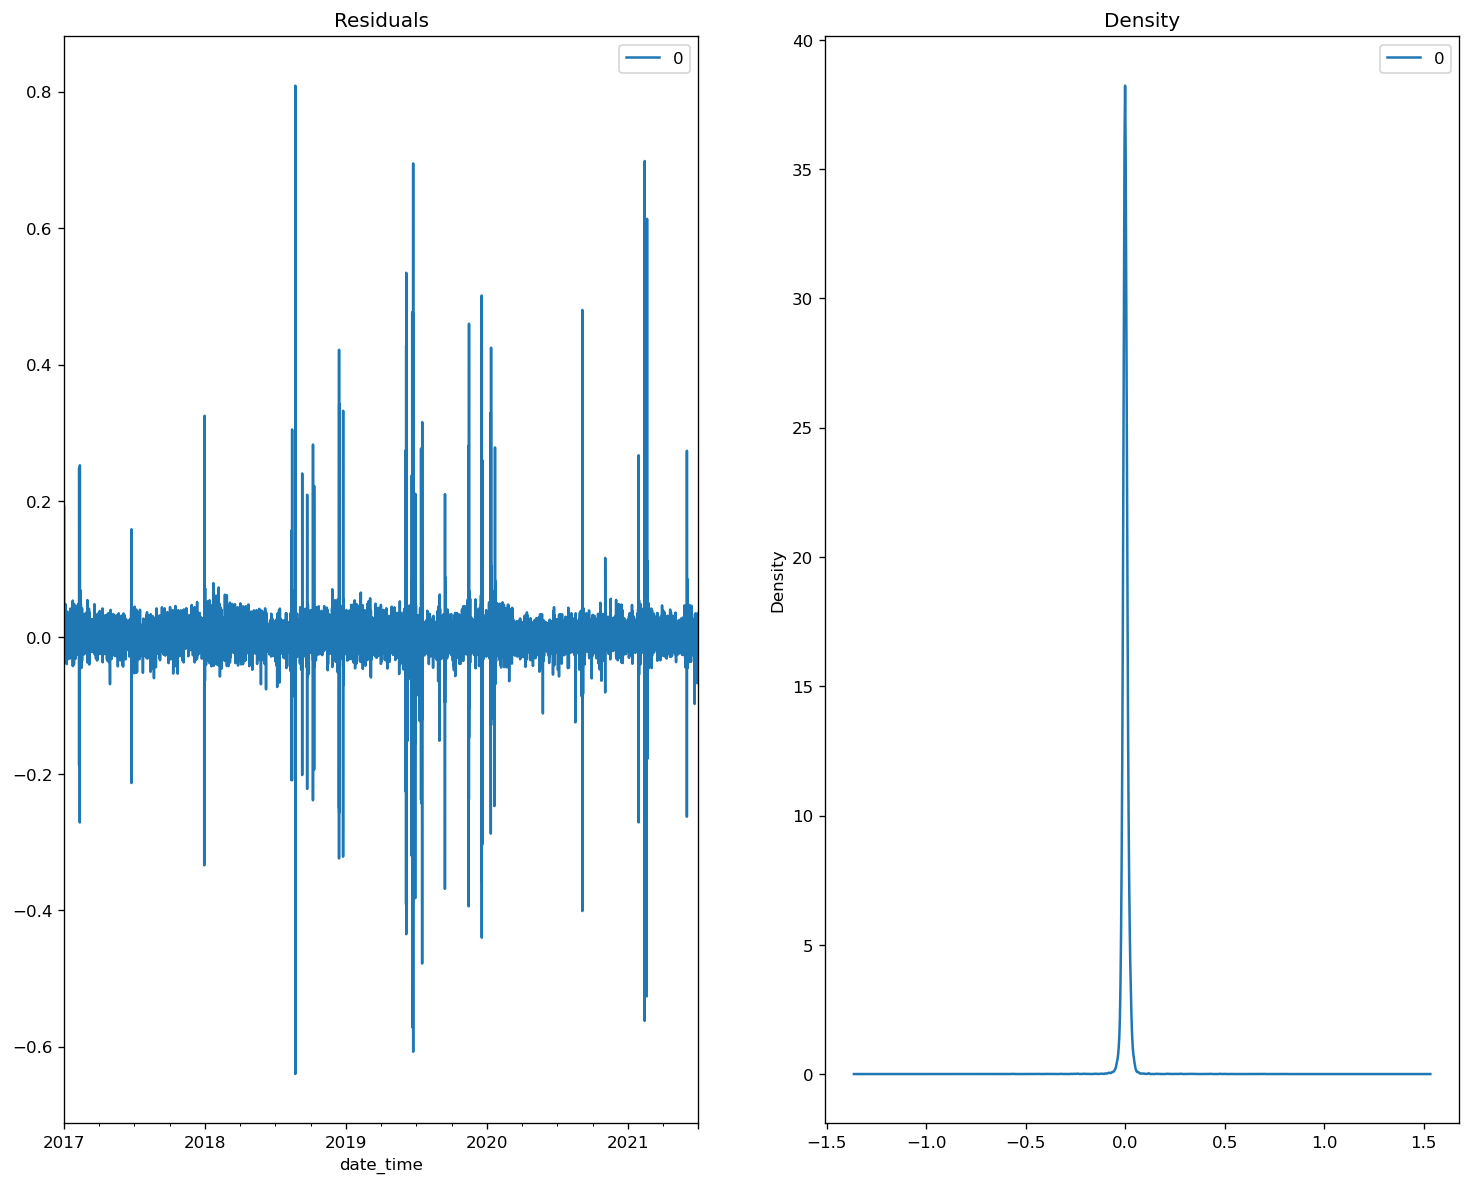

In [66]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

<AxesSubplot:xlabel='date_time'>

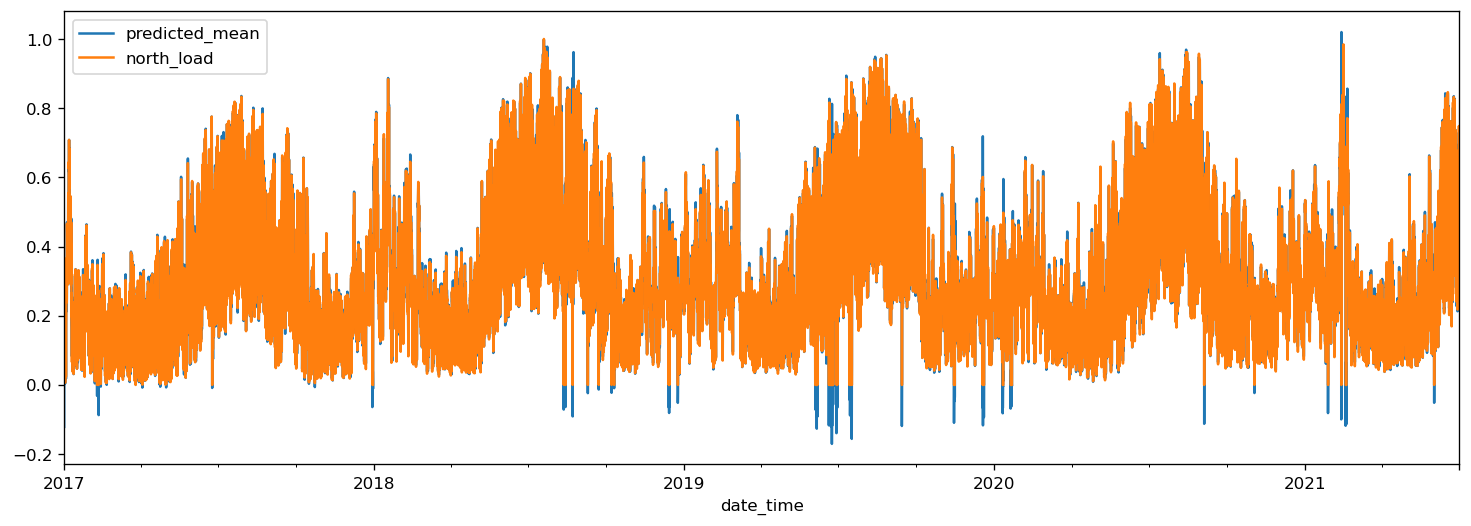

In [67]:
fig, ax = plt.subplots(figsize=(15, 5))
in_model_predictions = model_fit.predict()
in_model_predictions.plot(ax=ax, legend=True)
train_data.north_load.plot(ax=ax, legend=True)

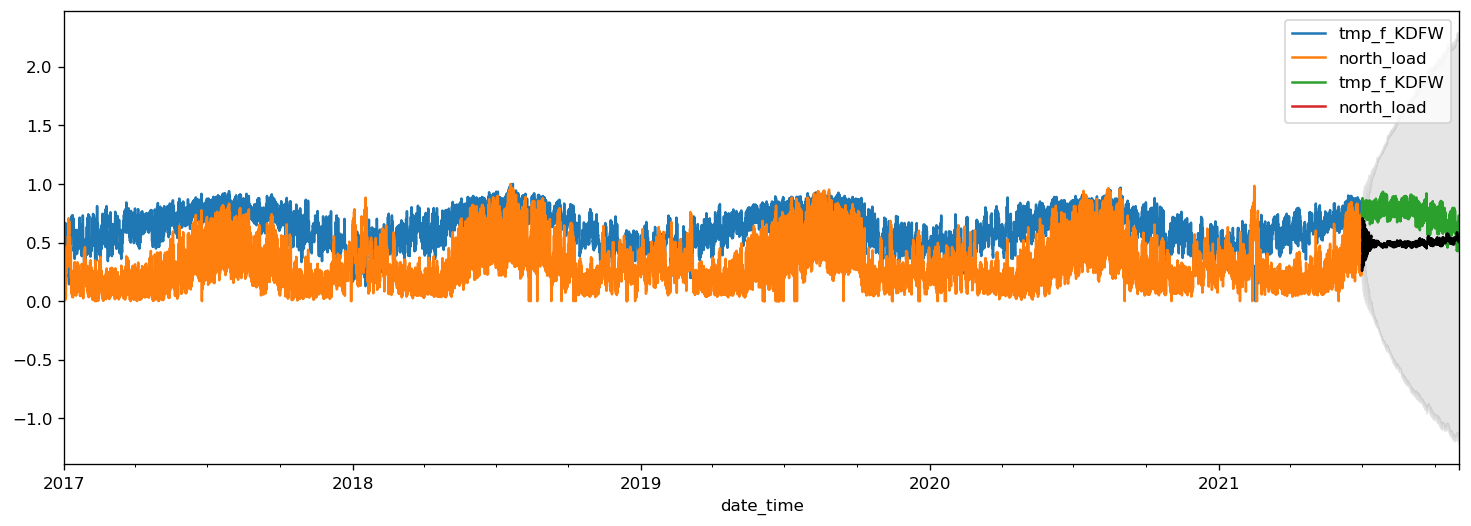

In [68]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2017-01-01':].plot(ax=ax)
target_trans = target_data.copy()
target_trans[['tmp_f_KDFW', 'north_load']] = scaler.transform(target_data[['tmp_f_KDFW', 'north_load']])
target_trans.plot(ax=ax)

# Construct the forecasts
fcast = model_fit.get_forecast(target_data.index[-1], exog=target_trans.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

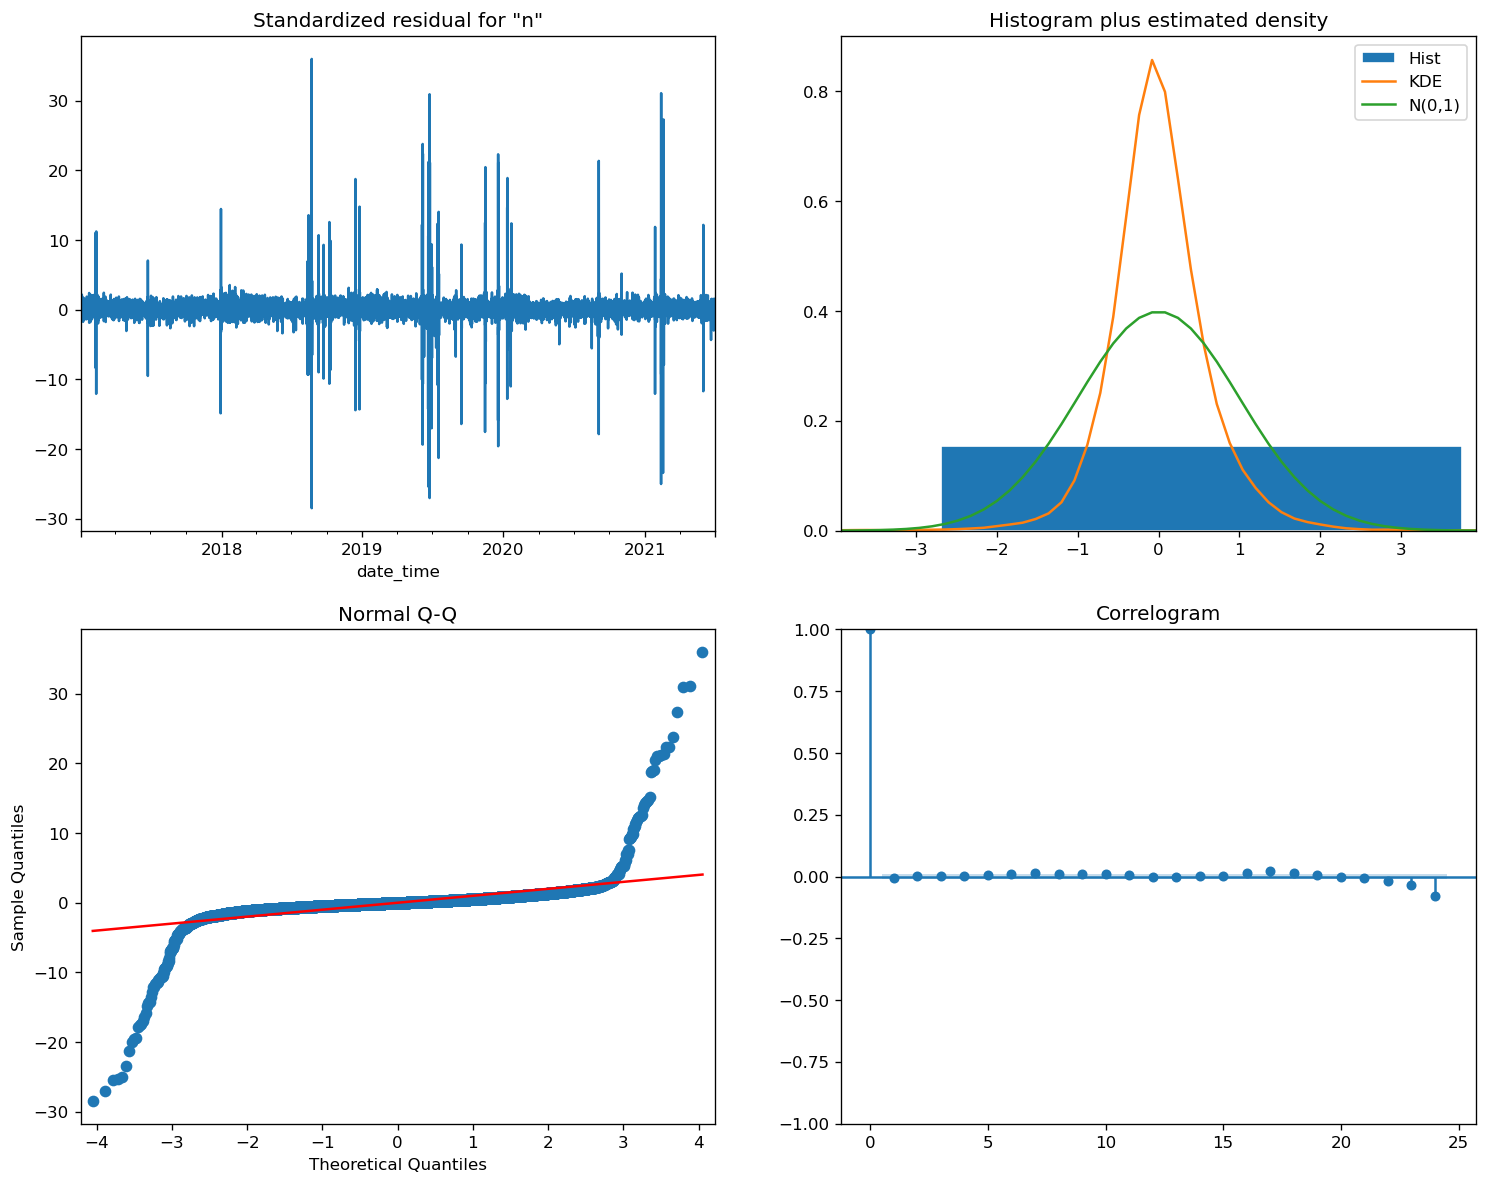

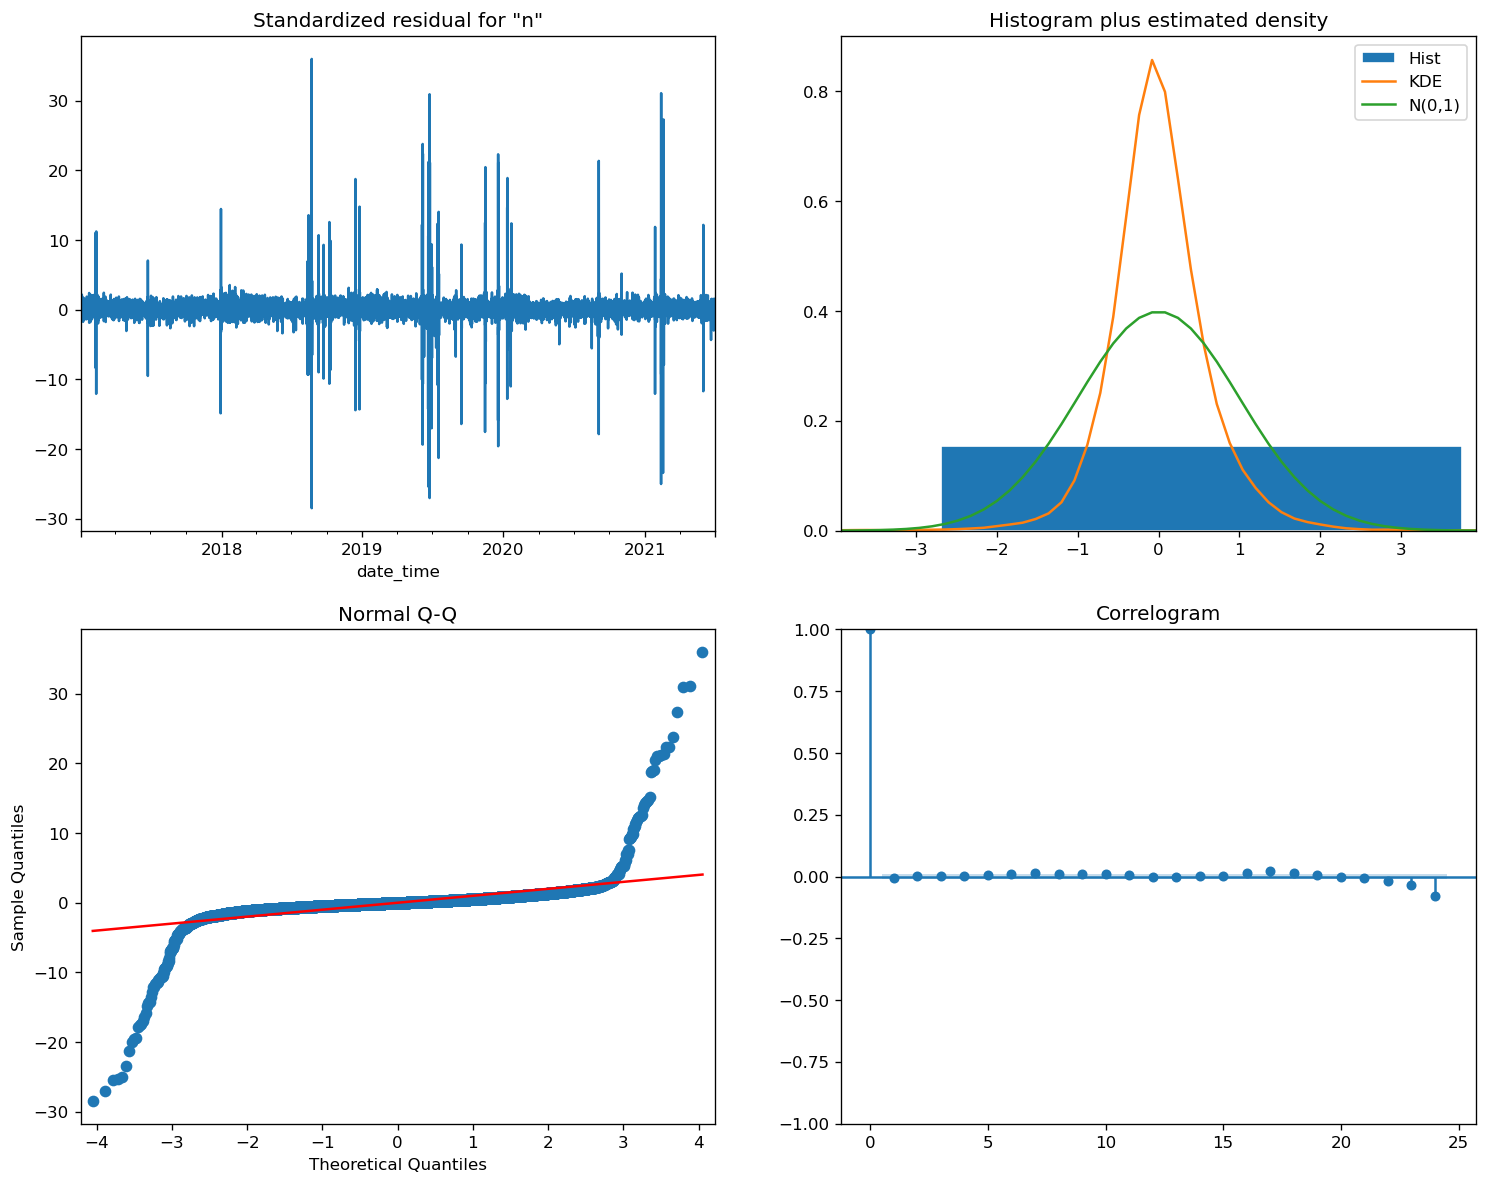

In [71]:
model_fit.plot_diagnostics(lags=24)

## Fit ARIMA(18, 1, 5) With Temperature and Linear Trend

In [72]:
model = sm.tsa.ARIMA(train_data.north_load, exog=train_data.tmp_f_KDFW, order=(18,1,5), trend='t')
model_fit = model.fit()
print(model_fit.summary())

/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:                ARIMA(18, 1, 5)   Log Likelihood               91820.105
Date:                Fri, 17 Jun 2022   AIC                        -183588.210
Time:                        22:27:30   BIC                        -183365.086
Sample:                    01-01-2017   HQIC                       -183517.535
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       5.898e-06   6.64e-05      0.089      0.929      -0.000       0.000
tmp_f_KDFW    -0.3479      0.002   -189.992      0.000      -0.351      -0.344
ar.L1          0.1301      0.029      4.505      0.0

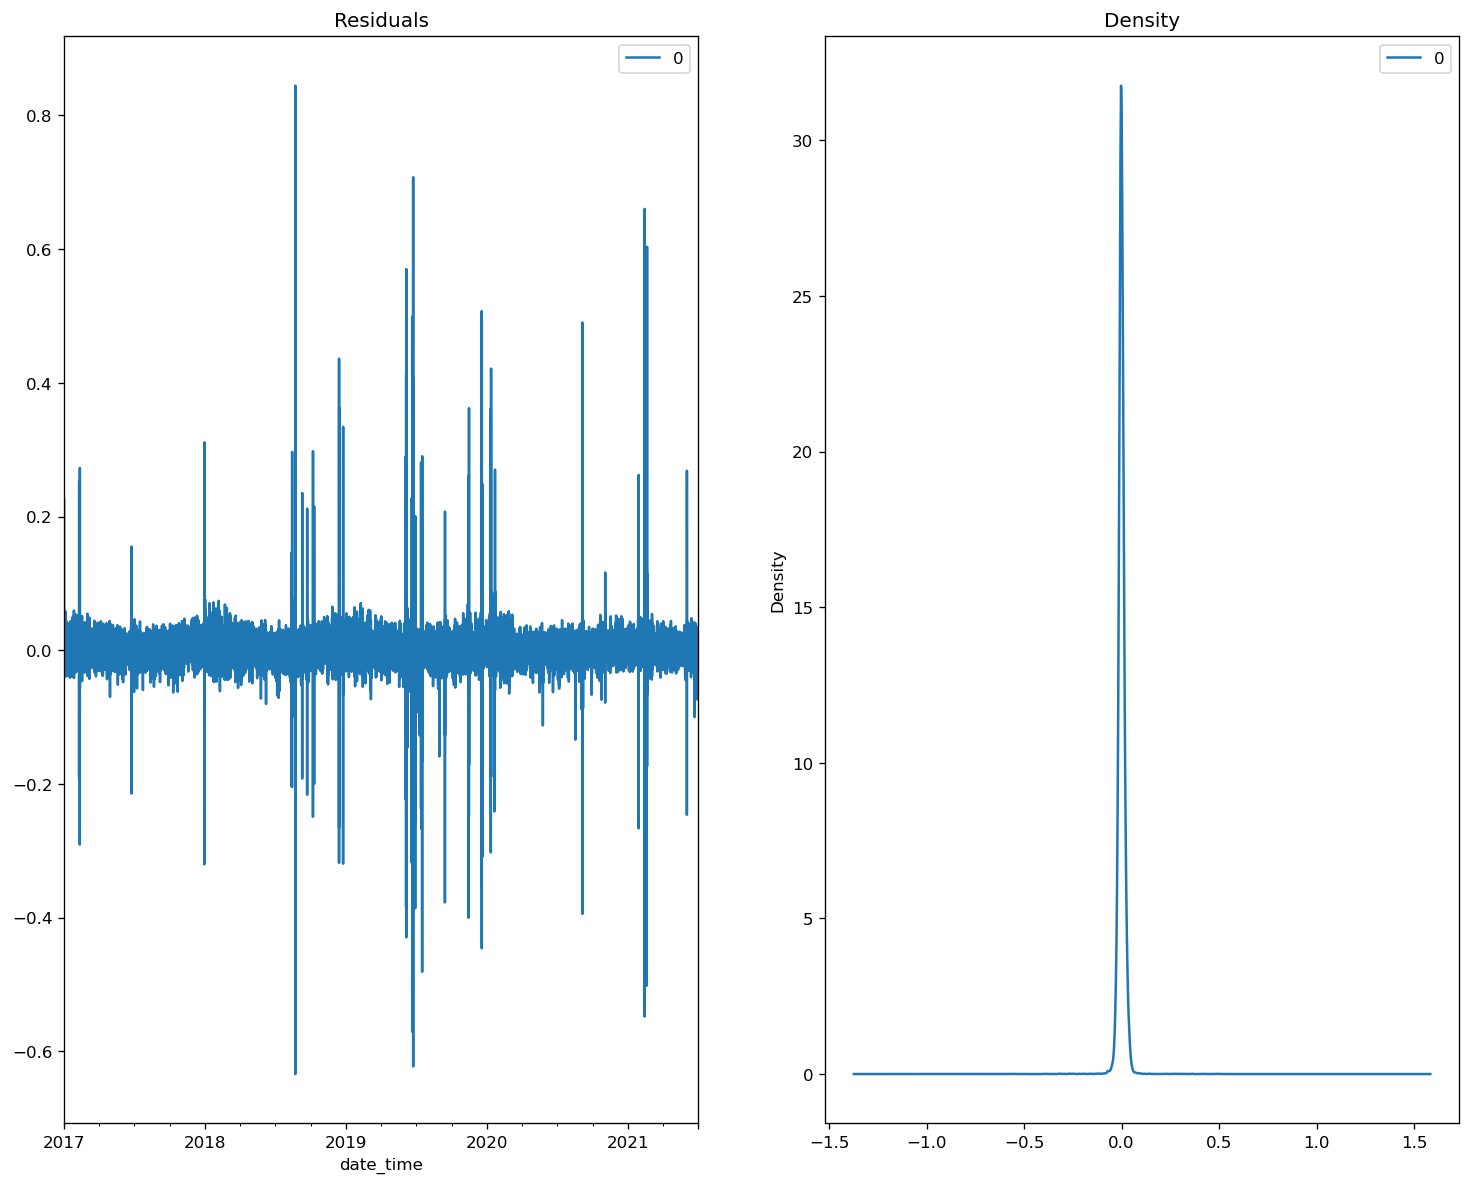

In [73]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

<AxesSubplot:xlabel='date_time'>

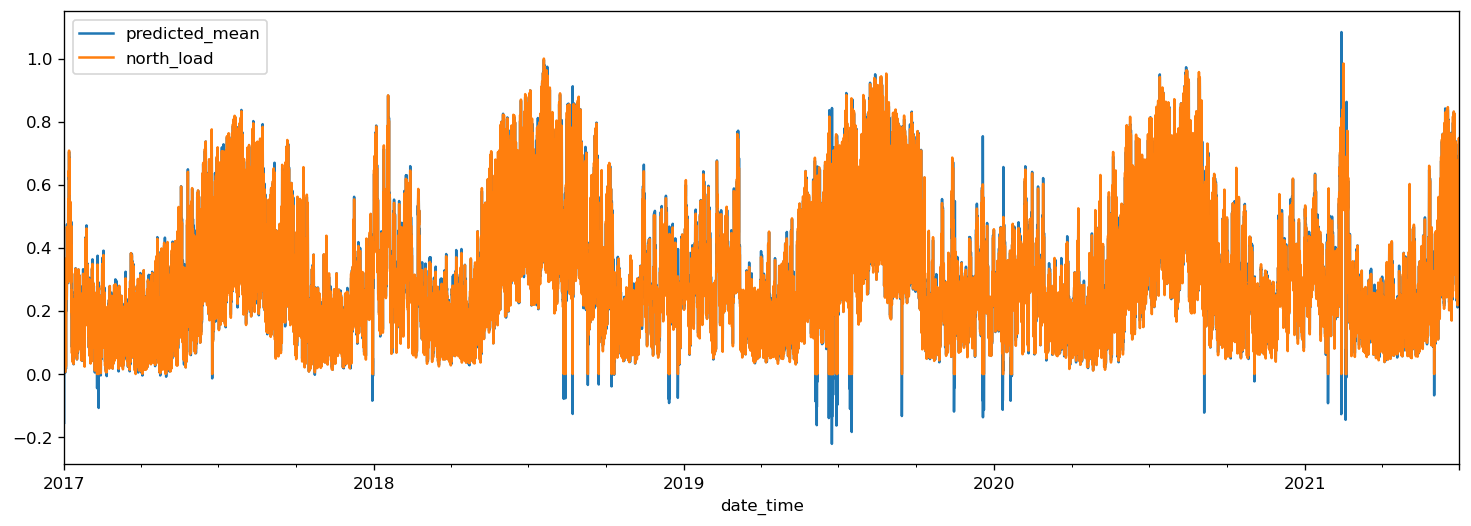

In [74]:
fig, ax = plt.subplots(figsize=(15, 5))
in_model_predictions = model_fit.predict()
in_model_predictions.plot(ax=ax, legend=True)
train_data.north_load.plot(ax=ax, legend=True)

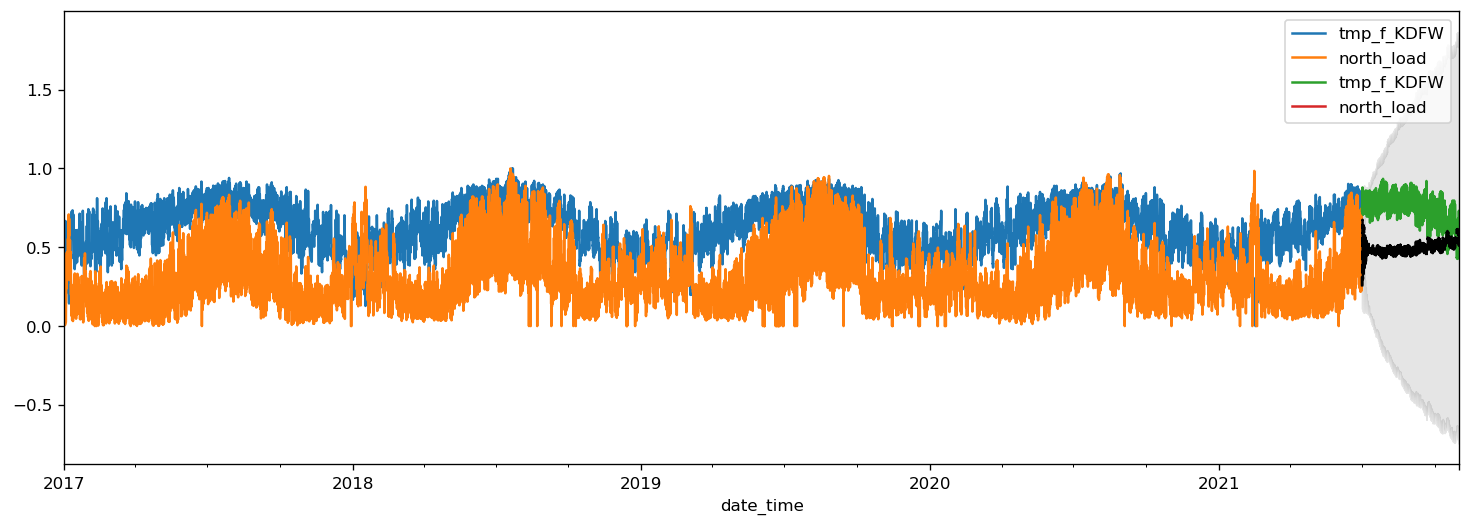

In [75]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2017-01-01':].plot(ax=ax)
target_trans = target_data.copy()
target_trans[['tmp_f_KDFW', 'north_load']] = scaler.transform(target_data[['tmp_f_KDFW', 'north_load']])
target_trans.plot(ax=ax)

# Construct the forecasts
fcast = model_fit.get_forecast(target_data.index[-1], exog=target_trans.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

Above suggests the MA terms aren't statistically significant with the trend so we'll take those out
## Fit ARIMA(18, 1, 1) With Temperature and Linear Trend

In [76]:
model = sm.tsa.ARIMA(train_data.north_load, exog=train_data.tmp_f_KDFW, order=(18,1,1), trend='t')
model_fit = model.fit()
print(model_fit.summary())

/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:                ARIMA(18, 1, 1)   Log Likelihood               91812.177
Date:                Fri, 17 Jun 2022   AIC                        -183580.353
Time:                        22:41:01   BIC                        -183391.556
Sample:                    01-01-2017   HQIC                       -183520.552
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       1.076e-06   6.32e-05      0.017      0.986      -0.000       0.000
tmp_f_KDFW    -0.3424      0.002   -188.101      0.000      -0.346      -0.339
ar.L1          0.1287      0.023      5.699      0.0

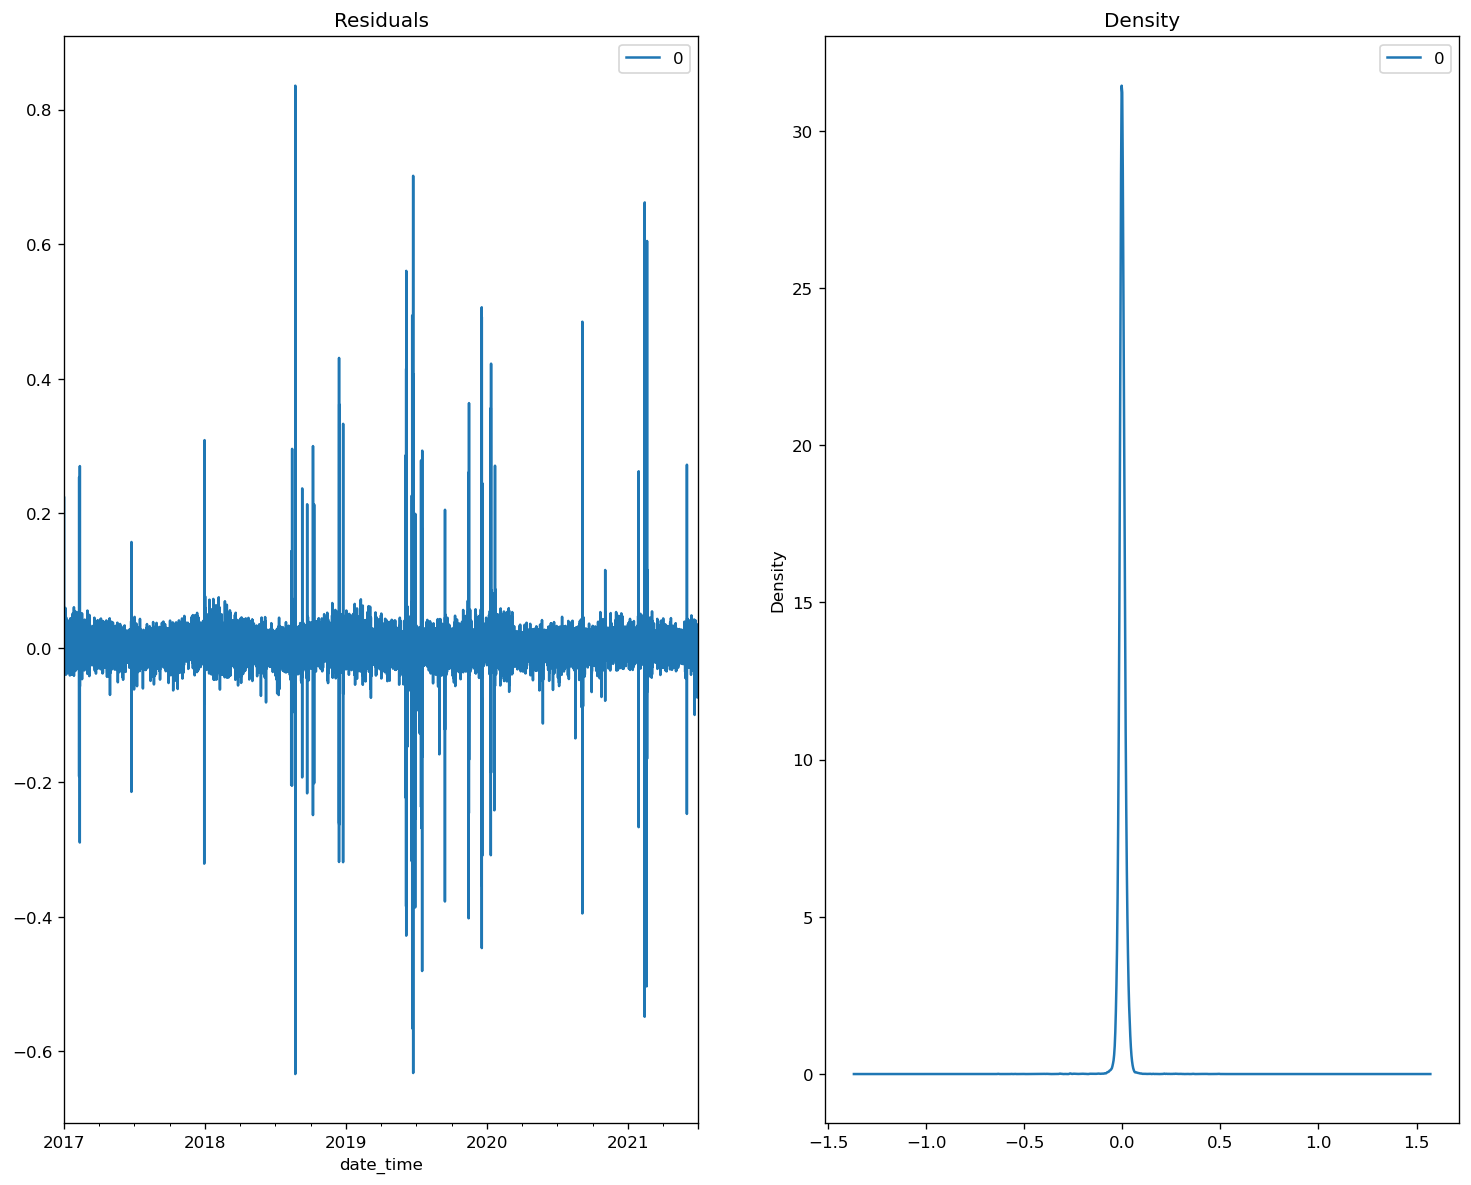

In [77]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

<AxesSubplot:xlabel='date_time'>

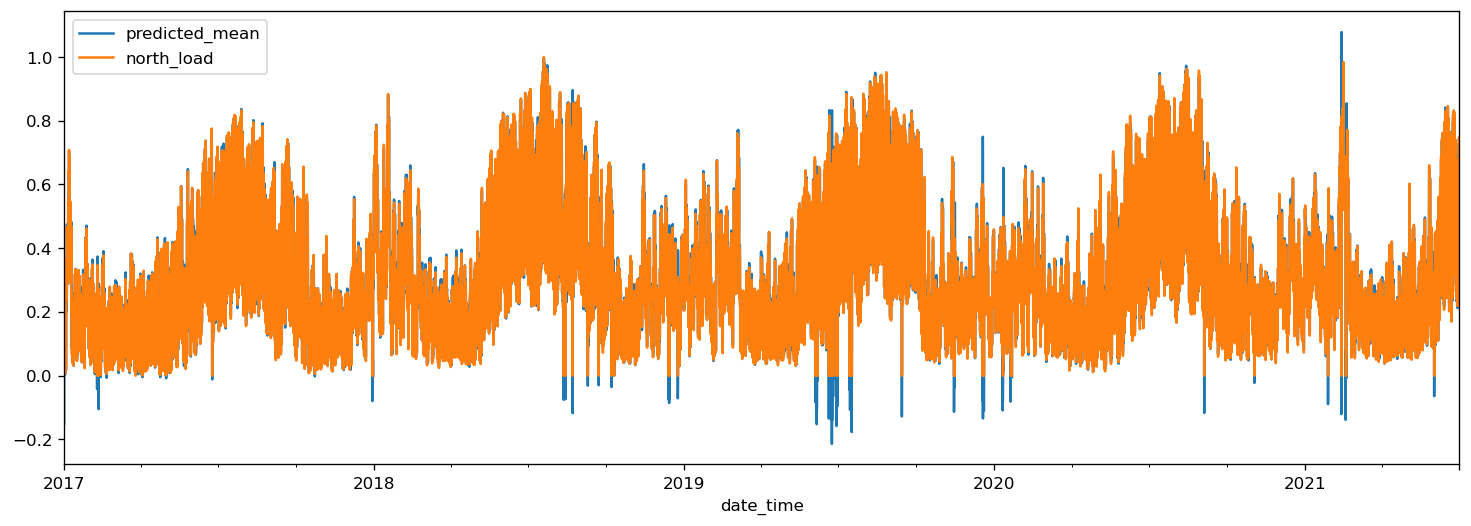

In [78]:
fig, ax = plt.subplots(figsize=(15, 5))
in_model_predictions = model_fit.predict()
in_model_predictions.plot(ax=ax, legend=True)
train_data.north_load.plot(ax=ax, legend=True)

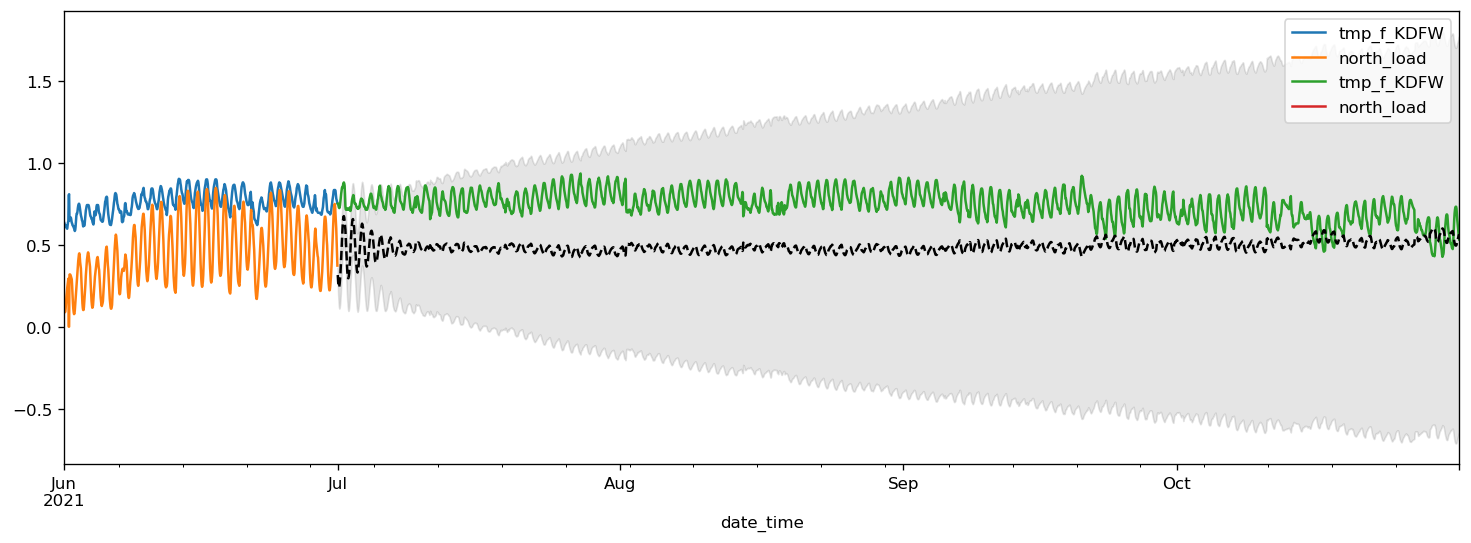

In [81]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2021-06-01':].plot(ax=ax)
target_trans = target_data.copy()
target_trans[['tmp_f_KDFW', 'north_load']] = scaler.transform(target_data[['tmp_f_KDFW', 'north_load']])
target_trans.plot(ax=ax)

# Construct the forecasts
fcast = model_fit.get_forecast(target_data.index[-1], exog=target_trans.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

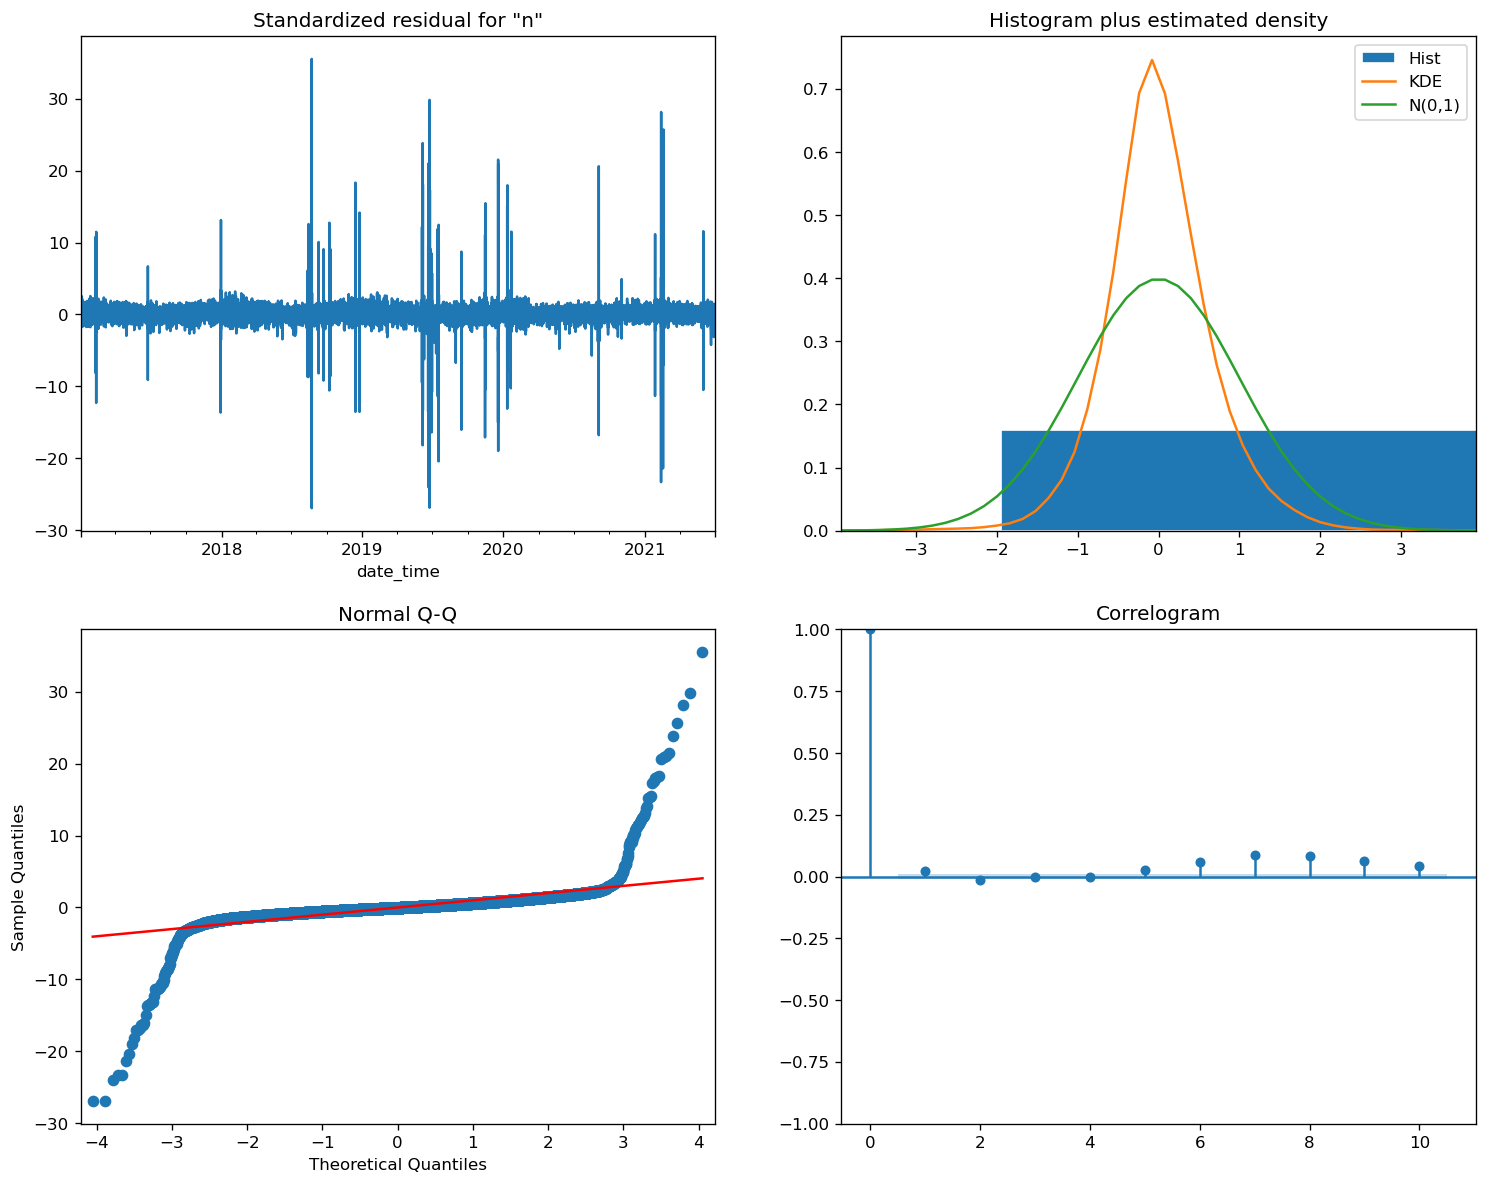

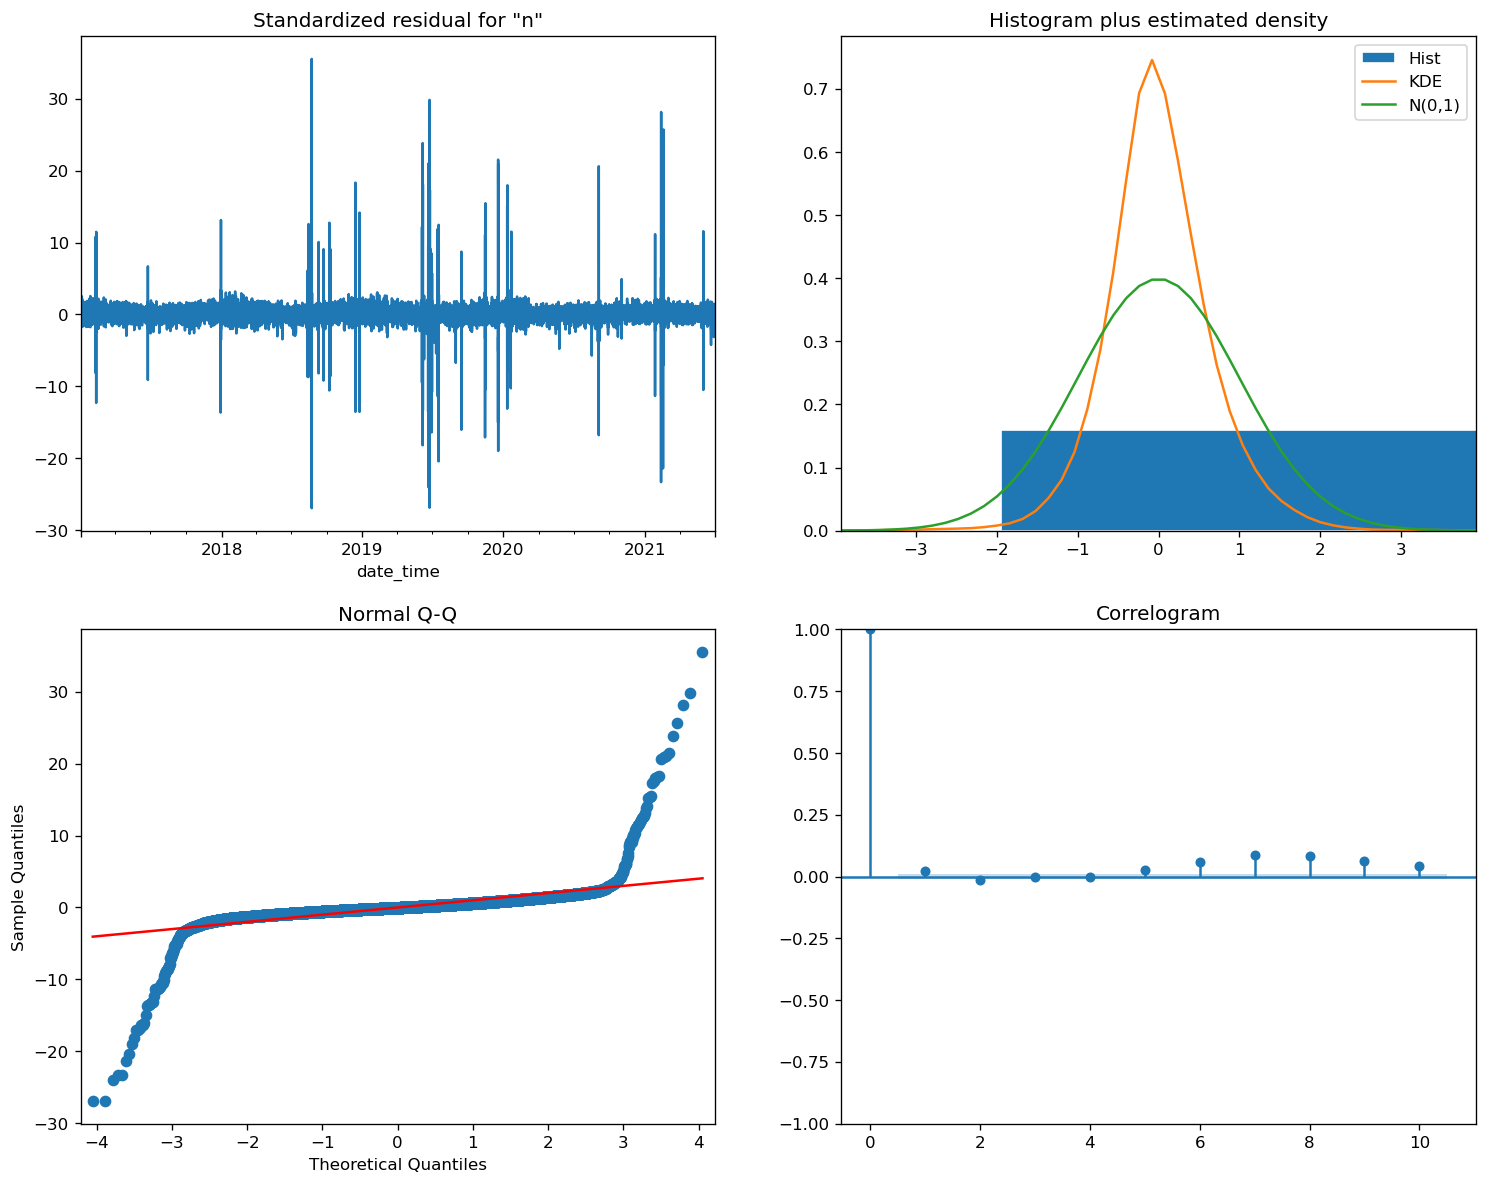

In [80]:
model_fit.plot_diagnostics()